In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ---------------------------------------
# 1. Data Loading and Inspection
# ---------------------------------------
train_data = pd.read_csv('/content/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/Google_Stock_Price_Test.csv')

print("Training Data Sample:\n", train_data.head())
print("Test Data Sample:\n", test_data.head())
print("Missing values in training data:\n", train_data.isnull().sum())

Training Data Sample:
        Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Test Data Sample:
        Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
Missing values in training data:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# ---------------------------------------
# 2. Data Cleaning and Preprocessing
# ---------------------------------------
features = ['Open', 'High', 'Low', 'Close']

# Convert columns that are object type with commas into float
for feature in features:
    if train_data[feature].dtype == 'object':
        train_data[feature] = train_data[feature].str.replace(',', '', regex=True).astype(float)
    if test_data[feature].dtype == 'object':
        test_data[feature] = test_data[feature].str.replace(',', '', regex=True).astype(float)

training_set = train_data[features].values
test_set = test_data[features].values

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [ ]:
# ---------------------------------------
# 3. Fixed-length Sequence Creation (Sliding Window)
# ---------------------------------------
N = 30  # number of past days used as input
M = 1   # number of future days to predict

X, y = [], []
for i in range(N, len(training_set_scaled) - M + 1):
    X.append(training_set_scaled[i-N:i, :])
    y.append(training_set_scaled[i:i+M, :])

X, y = np.array(X), np.array(y)

# Split into training and validation sets (time-aware)
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [ ]:
# ---------------------------------------
# 4. Dataset and DataLoader
# ---------------------------------------
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# ---------------------------------------
# Attention-Based GRU Model Definition
# ---------------------------------------
class GRUModel(nn.Module):#Attention
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)  # Compute attention scores
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [B, T, input_dim]
        gru_out, _ = self.gru(x)  # gru_out: [B, T, hidden_dim]

        # Compute attention scores
        attn_scores = self.attention(gru_out)  # attn_scores: [B, T, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)  # Normalize scores: [B, T, 1]

        # Compute context vector as weighted sum of GRU outputs
        context_vector = torch.sum(attn_weights * gru_out, dim=1)  # context_vector: [B, hidden_dim]

        # Pass the context vector through the fully connected layer
        out = self.fc(context_vector)  # out: [B, output_dim]
        return out

In [ ]:
# ---------------------------------------
# 6. Custom Asymmetric Loss Function
# ---------------------------------------
class AsymmetricLoss(nn.Module):
    def __init__(self, ratio=2.0):
        super(AsymmetricLoss, self).__init__()
        self.ratio = ratio

    def forward(self, pred, target):
        diff = target - pred
        loss = torch.mean(torch.where(diff > 0, self.ratio * diff**2, diff**2))
        return loss

In [ ]:
# ---------------------------------------
# 7. Training Function with Metric Logging
# ---------------------------------------
def train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(outputs.shape))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.view(outputs.shape))
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return best_state, best_val_loss, train_losses, val_losses

In [ ]:
# ---------------------------------------
# 8. Hyperparameter Tuning with Optuna
# ---------------------------------------
def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 50, 300)  # Slightly broader range
    num_layers = trial.suggest_int('num_layers', 1, 3)  # Adding number of layers
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)  # Regularization
    ratio = trial.suggest_float('asymmetric_ratio', 1.0, 5.0)

    # Define model
    model = GRUModel(
        input_dim=len(features),
        hidden_dim=hidden_dim,
        output_dim=len(features),
        num_layers=num_layers
    ).to(device)

    # Add dropout (if not in your model, add it in the forward method)
    if hasattr(model, 'dropout'):
        model.dropout = nn.Dropout(dropout)

    # Loss function and optimizer
    criterion = AsymmetricLoss(ratio=ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=7)

    # Shorter training for hyperparameter tuning
    best_state, best_val_loss, _, _ = train_and_validate(
        model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=40
    )
    return best_val_loss


# Configure and run the Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2024-12-06 23:21:04,650] A new study created in memory with name: no-name-e3262291-0f15-4248-a1c4-cb5a47f3c0ac


Epoch 1/40, Train Loss: 0.1949, Val Loss: 0.0415
Epoch 2/40, Train Loss: 0.1009, Val Loss: 0.0713
Epoch 3/40, Train Loss: 0.0691, Val Loss: 0.0733
Epoch 4/40, Train Loss: 0.0569, Val Loss: 0.0574
Epoch 5/40, Train Loss: 0.0480, Val Loss: 0.0399
Epoch 6/40, Train Loss: 0.0412, Val Loss: 0.0249
Epoch 7/40, Train Loss: 0.0354, Val Loss: 0.0132
Epoch 8/40, Train Loss: 0.0293, Val Loss: 0.0045
Epoch 9/40, Train Loss: 0.0234, Val Loss: 0.0061
Epoch 10/40, Train Loss: 0.0196, Val Loss: 0.0165
Epoch 11/40, Train Loss: 0.0100, Val Loss: 0.0046
Epoch 12/40, Train Loss: 0.0121, Val Loss: 0.0050
Epoch 13/40, Train Loss: 0.0134, Val Loss: 0.0046
Epoch 14/40, Train Loss: 0.0104, Val Loss: 0.0047
Epoch 15/40, Train Loss: 0.0115, Val Loss: 0.0038
Epoch 16/40, Train Loss: 0.0127, Val Loss: 0.0042
Epoch 17/40, Train Loss: 0.0099, Val Loss: 0.0038
Epoch 18/40, Train Loss: 0.0097, Val Loss: 0.0043
Epoch 19/40, Train Loss: 0.0113, Val Loss: 0.0041
Epoch 20/40, Train Loss: 0.0091, Val Loss: 0.0037
Epoch 21/

[I 2024-12-06 23:21:10,021] Trial 0 finished with value: 0.003558092277671676 and parameters: {'hidden_dim': 265, 'num_layers': 1, 'lr': 0.00034395988191647444, 'weight_decay': 4.752190596886157e-06, 'dropout': 0.35261971082540566, 'asymmetric_ratio': 4.065331161218892}. Best is trial 0 with value: 0.003558092277671676.


Epoch 40/40, Train Loss: 0.0061, Val Loss: 0.0051
Epoch 1/40, Train Loss: 0.0371, Val Loss: 0.0591
Epoch 2/40, Train Loss: 0.0896, Val Loss: 0.0261
Epoch 3/40, Train Loss: 0.0768, Val Loss: 0.0519
Epoch 4/40, Train Loss: 0.0700, Val Loss: 0.0243
Epoch 5/40, Train Loss: 0.0772, Val Loss: 0.0214
Epoch 6/40, Train Loss: 0.0454, Val Loss: 0.0152
Epoch 7/40, Train Loss: 0.0231, Val Loss: 0.0095
Epoch 8/40, Train Loss: 0.0435, Val Loss: 0.0253
Epoch 9/40, Train Loss: 0.0223, Val Loss: 0.0122
Epoch 10/40, Train Loss: 0.0206, Val Loss: 0.0054
Epoch 11/40, Train Loss: 0.0273, Val Loss: 0.0182
Epoch 12/40, Train Loss: 0.0156, Val Loss: 0.0280
Epoch 13/40, Train Loss: 0.0185, Val Loss: 0.0121
Epoch 14/40, Train Loss: 0.0143, Val Loss: 0.0267
Epoch 15/40, Train Loss: 0.0469, Val Loss: 0.0294
Epoch 16/40, Train Loss: 0.0207, Val Loss: 0.0101
Epoch 17/40, Train Loss: 0.0349, Val Loss: 0.0363
Epoch 18/40, Train Loss: 0.0450, Val Loss: 0.0360
Epoch 19/40, Train Loss: 0.0591, Val Loss: 0.0116
Epoch 20/

[I 2024-12-06 23:21:15,557] Trial 1 finished with value: 0.003770197115954943 and parameters: {'hidden_dim': 151, 'num_layers': 2, 'lr': 0.0029560579175928296, 'weight_decay': 9.58773669843905e-06, 'dropout': 0.3354339112669227, 'asymmetric_ratio': 3.085148901454097}. Best is trial 0 with value: 0.003558092277671676.


Epoch 40/40, Train Loss: 0.0046, Val Loss: 0.0053
Epoch 1/40, Train Loss: 0.2740, Val Loss: 0.0811
Epoch 2/40, Train Loss: 0.1099, Val Loss: 0.1358
Epoch 3/40, Train Loss: 0.0647, Val Loss: 0.0897
Epoch 4/40, Train Loss: 0.0579, Val Loss: 0.0691
Epoch 5/40, Train Loss: 0.0518, Val Loss: 0.0534
Epoch 6/40, Train Loss: 0.0457, Val Loss: 0.0403
Epoch 7/40, Train Loss: 0.0401, Val Loss: 0.0300
Epoch 8/40, Train Loss: 0.0352, Val Loss: 0.0218
Epoch 9/40, Train Loss: 0.0304, Val Loss: 0.0145
Epoch 10/40, Train Loss: 0.0246, Val Loss: 0.0073
Epoch 11/40, Train Loss: 0.0179, Val Loss: 0.0044
Epoch 12/40, Train Loss: 0.0137, Val Loss: 0.0042
Epoch 13/40, Train Loss: 0.0115, Val Loss: 0.0040
Epoch 14/40, Train Loss: 0.0113, Val Loss: 0.0050
Epoch 15/40, Train Loss: 0.0127, Val Loss: 0.0050
Epoch 16/40, Train Loss: 0.0108, Val Loss: 0.0039
Epoch 17/40, Train Loss: 0.0105, Val Loss: 0.0067
Epoch 18/40, Train Loss: 0.0127, Val Loss: 0.0042
Epoch 19/40, Train Loss: 0.0118, Val Loss: 0.0043
Epoch 20/

[I 2024-12-06 23:21:20,741] Trial 2 finished with value: 0.003889766725478694 and parameters: {'hidden_dim': 271, 'num_layers': 1, 'lr': 0.000249332330738677, 'weight_decay': 0.00033463179733326994, 'dropout': 0.18455072496350342, 'asymmetric_ratio': 4.223205474110094}. Best is trial 0 with value: 0.003558092277671676.


Epoch 40/40, Train Loss: 0.0075, Val Loss: 0.0051
Epoch 1/40, Train Loss: 0.2602, Val Loss: 0.0872
Epoch 2/40, Train Loss: 0.1280, Val Loss: 0.1728
Epoch 3/40, Train Loss: 0.0738, Val Loss: 0.1136
Epoch 4/40, Train Loss: 0.0642, Val Loss: 0.0821
Epoch 5/40, Train Loss: 0.0540, Val Loss: 0.0561
Epoch 6/40, Train Loss: 0.0435, Val Loss: 0.0359
Epoch 7/40, Train Loss: 0.0343, Val Loss: 0.0216
Epoch 8/40, Train Loss: 0.0260, Val Loss: 0.0106
Epoch 9/40, Train Loss: 0.0176, Val Loss: 0.0045
Epoch 10/40, Train Loss: 0.0122, Val Loss: 0.0041
Epoch 11/40, Train Loss: 0.0116, Val Loss: 0.0041
Epoch 12/40, Train Loss: 0.0120, Val Loss: 0.0047
Epoch 13/40, Train Loss: 0.0133, Val Loss: 0.0050
Epoch 14/40, Train Loss: 0.0108, Val Loss: 0.0039
Epoch 15/40, Train Loss: 0.0106, Val Loss: 0.0052
Epoch 16/40, Train Loss: 0.0121, Val Loss: 0.0050
Epoch 17/40, Train Loss: 0.0125, Val Loss: 0.0045
Epoch 18/40, Train Loss: 0.0107, Val Loss: 0.0039
Epoch 19/40, Train Loss: 0.0101, Val Loss: 0.0052
Epoch 20/

[I 2024-12-06 23:21:27,157] Trial 3 finished with value: 0.003811261660302989 and parameters: {'hidden_dim': 281, 'num_layers': 2, 'lr': 0.0001326584304744832, 'weight_decay': 2.703807433651837e-05, 'dropout': 0.11579496904374027, 'asymmetric_ratio': 4.102147049502494}. Best is trial 0 with value: 0.003558092277671676.


Epoch 40/40, Train Loss: 0.0075, Val Loss: 0.0058
Epoch 1/40, Train Loss: 0.0383, Val Loss: 0.0816
Epoch 2/40, Train Loss: 0.0974, Val Loss: 0.0214
Epoch 3/40, Train Loss: 0.0514, Val Loss: 0.0201
Epoch 4/40, Train Loss: 0.0313, Val Loss: 0.0153
Epoch 5/40, Train Loss: 0.0196, Val Loss: 0.0155
Epoch 6/40, Train Loss: 0.0151, Val Loss: 0.0096
Epoch 7/40, Train Loss: 0.0273, Val Loss: 0.0172
Epoch 8/40, Train Loss: 0.0203, Val Loss: 0.0127
Epoch 9/40, Train Loss: 0.0310, Val Loss: 0.0397
Epoch 10/40, Train Loss: 0.0092, Val Loss: 0.0036
Epoch 11/40, Train Loss: 0.0085, Val Loss: 0.0039
Epoch 12/40, Train Loss: 0.0113, Val Loss: 0.0057
Epoch 13/40, Train Loss: 0.0135, Val Loss: 0.0077
Epoch 14/40, Train Loss: 0.0088, Val Loss: 0.0033
Epoch 15/40, Train Loss: 0.0074, Val Loss: 0.0042
Epoch 16/40, Train Loss: 0.0101, Val Loss: 0.0056
Epoch 17/40, Train Loss: 0.0118, Val Loss: 0.0070
Epoch 18/40, Train Loss: 0.0078, Val Loss: 0.0035
Epoch 19/40, Train Loss: 0.0067, Val Loss: 0.0040
Epoch 20/

[I 2024-12-06 23:21:31,187] Trial 4 finished with value: 0.003128245924017392 and parameters: {'hidden_dim': 126, 'num_layers': 1, 'lr': 0.0014377741835761347, 'weight_decay': 0.0002089260875362206, 'dropout': 0.17180679235850538, 'asymmetric_ratio': 2.8739526485819358}. Best is trial 4 with value: 0.003128245924017392.


Epoch 40/40, Train Loss: 0.0049, Val Loss: 0.0035
Epoch 1/40, Train Loss: 0.0640, Val Loss: 0.1588
Epoch 2/40, Train Loss: 0.1127, Val Loss: 0.0424
Epoch 3/40, Train Loss: 0.0636, Val Loss: 0.0142
Epoch 4/40, Train Loss: 0.0385, Val Loss: 0.0205
Epoch 5/40, Train Loss: 0.0246, Val Loss: 0.0047
Epoch 6/40, Train Loss: 0.0232, Val Loss: 0.0147
Epoch 7/40, Train Loss: 0.0312, Val Loss: 0.0593
Epoch 8/40, Train Loss: 0.0095, Val Loss: 0.0036
Epoch 9/40, Train Loss: 0.0189, Val Loss: 0.0305
Epoch 10/40, Train Loss: 0.0151, Val Loss: 0.0116
Epoch 11/40, Train Loss: 0.0093, Val Loss: 0.0041
Epoch 12/40, Train Loss: 0.0112, Val Loss: 0.0066
Epoch 13/40, Train Loss: 0.0154, Val Loss: 0.0181
Epoch 14/40, Train Loss: 0.0114, Val Loss: 0.0069
Epoch 15/40, Train Loss: 0.0081, Val Loss: 0.0042
Epoch 16/40, Train Loss: 0.0124, Val Loss: 0.0100
Epoch 17/40, Train Loss: 0.0118, Val Loss: 0.0061
Epoch 18/40, Train Loss: 0.0074, Val Loss: 0.0044
Epoch 19/40, Train Loss: 0.0068, Val Loss: 0.0037
Epoch 20/

[I 2024-12-06 23:21:37,658] Trial 5 finished with value: 0.0032422315489384346 and parameters: {'hidden_dim': 197, 'num_layers': 2, 'lr': 0.0003652499247962543, 'weight_decay': 9.640052043684072e-05, 'dropout': 0.44178675371414367, 'asymmetric_ratio': 2.3548707682745413}. Best is trial 4 with value: 0.003128245924017392.


Epoch 40/40, Train Loss: 0.0060, Val Loss: 0.0032
Epoch 1/40, Train Loss: 0.0649, Val Loss: 0.1432
Epoch 2/40, Train Loss: 0.1452, Val Loss: 0.0187
Epoch 3/40, Train Loss: 0.0935, Val Loss: 0.0601
Epoch 4/40, Train Loss: 0.0493, Val Loss: 0.0310
Epoch 5/40, Train Loss: 0.0338, Val Loss: 0.0163
Epoch 6/40, Train Loss: 0.0184, Val Loss: 0.0129
Epoch 7/40, Train Loss: 0.0197, Val Loss: 0.0172
Epoch 8/40, Train Loss: 0.0267, Val Loss: 0.0186
Epoch 9/40, Train Loss: 0.0384, Val Loss: 0.0076
Epoch 10/40, Train Loss: 0.0624, Val Loss: 0.0297
Epoch 11/40, Train Loss: 0.0352, Val Loss: 0.0065
Epoch 12/40, Train Loss: 0.0813, Val Loss: 0.1224
Epoch 13/40, Train Loss: 0.0248, Val Loss: 0.0118
Epoch 14/40, Train Loss: 0.0180, Val Loss: 0.0047
Epoch 15/40, Train Loss: 0.0111, Val Loss: 0.0046
Epoch 16/40, Train Loss: 0.0116, Val Loss: 0.0060
Epoch 17/40, Train Loss: 0.0151, Val Loss: 0.0050
Epoch 18/40, Train Loss: 0.0121, Val Loss: 0.0040
Epoch 19/40, Train Loss: 0.0098, Val Loss: 0.0098
Epoch 20/

[I 2024-12-06 23:21:44,034] Trial 6 finished with value: 0.003909883482265286 and parameters: {'hidden_dim': 222, 'num_layers': 2, 'lr': 0.0006694604359286493, 'weight_decay': 1.2088542077120944e-06, 'dropout': 0.36878970898374797, 'asymmetric_ratio': 4.236120377239943}. Best is trial 4 with value: 0.003128245924017392.


Epoch 40/40, Train Loss: 0.0054, Val Loss: 0.0086
Epoch 1/40, Train Loss: 0.0643, Val Loss: 0.1473
Epoch 2/40, Train Loss: 0.1471, Val Loss: 0.0216
Epoch 3/40, Train Loss: 0.0969, Val Loss: 0.0520
Epoch 4/40, Train Loss: 0.0567, Val Loss: 0.0309
Epoch 5/40, Train Loss: 0.0371, Val Loss: 0.0219
Epoch 6/40, Train Loss: 0.0154, Val Loss: 0.0104
Epoch 7/40, Train Loss: 0.0187, Val Loss: 0.0077
Epoch 8/40, Train Loss: 0.0316, Val Loss: 0.0243
Epoch 9/40, Train Loss: 0.0504, Val Loss: 0.0368
Epoch 10/40, Train Loss: 0.0360, Val Loss: 0.0061
Epoch 11/40, Train Loss: 0.0474, Val Loss: 0.0556
Epoch 12/40, Train Loss: 0.0253, Val Loss: 0.0075
Epoch 13/40, Train Loss: 0.0236, Val Loss: 0.0111
Epoch 14/40, Train Loss: 0.0206, Val Loss: 0.0051
Epoch 15/40, Train Loss: 0.0131, Val Loss: 0.0112
Epoch 16/40, Train Loss: 0.0141, Val Loss: 0.0044
Epoch 17/40, Train Loss: 0.0155, Val Loss: 0.0056
Epoch 18/40, Train Loss: 0.0133, Val Loss: 0.0055
Epoch 19/40, Train Loss: 0.0157, Val Loss: 0.0044
Epoch 20/

[I 2024-12-06 23:21:48,603] Trial 7 finished with value: 0.003950152211473323 and parameters: {'hidden_dim': 109, 'num_layers': 2, 'lr': 0.001124431327701332, 'weight_decay': 6.392661212783061e-05, 'dropout': 0.1520777181663831, 'asymmetric_ratio': 4.644665248284989}. Best is trial 4 with value: 0.003128245924017392.


Epoch 40/40, Train Loss: 0.0057, Val Loss: 0.0080
Epoch 1/40, Train Loss: 0.0340, Val Loss: 0.0562
Epoch 2/40, Train Loss: 0.0713, Val Loss: 0.0859
Epoch 3/40, Train Loss: 0.1031, Val Loss: 0.0600
Epoch 4/40, Train Loss: 0.1132, Val Loss: 0.0106
Epoch 5/40, Train Loss: 0.1074, Val Loss: 0.0664
Epoch 6/40, Train Loss: 0.2639, Val Loss: 0.0625
Epoch 7/40, Train Loss: 0.0899, Val Loss: 0.0308
Epoch 8/40, Train Loss: 0.0412, Val Loss: 0.0271
Epoch 9/40, Train Loss: 0.0476, Val Loss: 0.0083
Epoch 10/40, Train Loss: 0.0816, Val Loss: 0.0191
Epoch 11/40, Train Loss: 0.0879, Val Loss: 0.1673
Epoch 12/40, Train Loss: 0.0581, Val Loss: 0.1328
Epoch 13/40, Train Loss: 0.0705, Val Loss: 0.1048
Epoch 14/40, Train Loss: 0.0293, Val Loss: 0.0170
Epoch 15/40, Train Loss: 0.0316, Val Loss: 0.0226
Epoch 16/40, Train Loss: 0.0358, Val Loss: 0.0695
Epoch 17/40, Train Loss: 0.0325, Val Loss: 0.0298
Epoch 18/40, Train Loss: 0.0260, Val Loss: 0.0366
Epoch 19/40, Train Loss: 0.0212, Val Loss: 0.0316
Epoch 20/

[I 2024-12-06 23:21:55,091] Trial 8 finished with value: 0.008343730121850967 and parameters: {'hidden_dim': 263, 'num_layers': 2, 'lr': 0.003479815724352986, 'weight_decay': 1.88944073577761e-06, 'dropout': 0.34625231594291056, 'asymmetric_ratio': 2.809279187464062}. Best is trial 4 with value: 0.003128245924017392.


Epoch 40/40, Train Loss: 0.0156, Val Loss: 0.0103
Epoch 1/40, Train Loss: 0.1332, Val Loss: 0.0347
Epoch 2/40, Train Loss: 0.1434, Val Loss: 0.1199
Epoch 3/40, Train Loss: 0.0952, Val Loss: 0.1005
Epoch 4/40, Train Loss: 0.0735, Val Loss: 0.0700
Epoch 5/40, Train Loss: 0.0542, Val Loss: 0.0343
Epoch 6/40, Train Loss: 0.0443, Val Loss: 0.0168
Epoch 7/40, Train Loss: 0.0356, Val Loss: 0.0118
Epoch 8/40, Train Loss: 0.0221, Val Loss: 0.0098
Epoch 9/40, Train Loss: 0.0175, Val Loss: 0.0066
Epoch 10/40, Train Loss: 0.0166, Val Loss: 0.0091
Epoch 11/40, Train Loss: 0.0193, Val Loss: 0.0131
Epoch 12/40, Train Loss: 0.0140, Val Loss: 0.0055
Epoch 13/40, Train Loss: 0.0116, Val Loss: 0.0048
Epoch 14/40, Train Loss: 0.0176, Val Loss: 0.0124
Epoch 15/40, Train Loss: 0.0158, Val Loss: 0.0085
Epoch 16/40, Train Loss: 0.0116, Val Loss: 0.0048
Epoch 17/40, Train Loss: 0.0130, Val Loss: 0.0070
Epoch 18/40, Train Loss: 0.0154, Val Loss: 0.0089
Epoch 19/40, Train Loss: 0.0133, Val Loss: 0.0061
Epoch 20/

[I 2024-12-06 23:22:02,772] Trial 9 finished with value: 0.004095808035344817 and parameters: {'hidden_dim': 205, 'num_layers': 3, 'lr': 0.0001797128666834116, 'weight_decay': 0.00047246063264796853, 'dropout': 0.1436713454021085, 'asymmetric_ratio': 4.003012233495014}. Best is trial 4 with value: 0.003128245924017392.


Epoch 39/40, Train Loss: 0.0077, Val Loss: 0.0041
Epoch 40/40, Train Loss: 0.0077, Val Loss: 0.0041
Epoch 1/40, Train Loss: 0.0280, Val Loss: 0.0177
Epoch 2/40, Train Loss: 0.0595, Val Loss: 0.0342
Epoch 3/40, Train Loss: 0.0435, Val Loss: 0.0200
Epoch 4/40, Train Loss: 0.0352, Val Loss: 0.0112
Epoch 5/40, Train Loss: 0.0302, Val Loss: 0.0202
Epoch 6/40, Train Loss: 0.0195, Val Loss: 0.0176
Epoch 7/40, Train Loss: 0.0158, Val Loss: 0.0079
Epoch 8/40, Train Loss: 0.0128, Val Loss: 0.0072
Epoch 9/40, Train Loss: 0.0126, Val Loss: 0.0088
Epoch 10/40, Train Loss: 0.0129, Val Loss: 0.0064
Epoch 11/40, Train Loss: 0.0113, Val Loss: 0.0053
Epoch 12/40, Train Loss: 0.0092, Val Loss: 0.0041
Epoch 13/40, Train Loss: 0.0086, Val Loss: 0.0039
Epoch 14/40, Train Loss: 0.0067, Val Loss: 0.0056
Epoch 15/40, Train Loss: 0.0053, Val Loss: 0.0048
Epoch 16/40, Train Loss: 0.0061, Val Loss: 0.0056
Epoch 17/40, Train Loss: 0.0064, Val Loss: 0.0024
Epoch 18/40, Train Loss: 0.0102, Val Loss: 0.0121
Epoch 19/

[I 2024-12-06 23:22:06,751] Trial 10 finished with value: 0.002384215986239724 and parameters: {'hidden_dim': 50, 'num_layers': 1, 'lr': 0.008321569759923118, 'weight_decay': 0.0008642869898355729, 'dropout': 0.24863754928925902, 'asymmetric_ratio': 1.2867881298462875}. Best is trial 10 with value: 0.002384215986239724.


Epoch 38/40, Train Loss: 0.0044, Val Loss: 0.0029
Epoch 39/40, Train Loss: 0.0044, Val Loss: 0.0029
Epoch 40/40, Train Loss: 0.0044, Val Loss: 0.0029
Epoch 1/40, Train Loss: 0.0226, Val Loss: 0.0180
Epoch 2/40, Train Loss: 0.0480, Val Loss: 0.0457
Epoch 3/40, Train Loss: 0.0333, Val Loss: 0.0126
Epoch 4/40, Train Loss: 0.0308, Val Loss: 0.0089
Epoch 5/40, Train Loss: 0.0247, Val Loss: 0.0106
Epoch 6/40, Train Loss: 0.0222, Val Loss: 0.0131
Epoch 7/40, Train Loss: 0.0179, Val Loss: 0.0045
Epoch 8/40, Train Loss: 0.0151, Val Loss: 0.0080
Epoch 9/40, Train Loss: 0.0117, Val Loss: 0.0042
Epoch 10/40, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 11/40, Train Loss: 0.0077, Val Loss: 0.0080
Epoch 12/40, Train Loss: 0.0099, Val Loss: 0.0073
Epoch 13/40, Train Loss: 0.0076, Val Loss: 0.0039
Epoch 14/40, Train Loss: 0.0079, Val Loss: 0.0064
Epoch 15/40, Train Loss: 0.0080, Val Loss: 0.0043
Epoch 16/40, Train Loss: 0.0068, Val Loss: 0.0050
Epoch 17/40, Train Loss: 0.0070, Val Loss: 0.0055
Epoch 18/

[I 2024-12-06 23:22:10,740] Trial 11 finished with value: 0.003854636976029724 and parameters: {'hidden_dim': 57, 'num_layers': 1, 'lr': 0.007400483218348517, 'weight_decay': 0.0008945238305968808, 'dropout': 0.21278832724568303, 'asymmetric_ratio': 1.0152661178021702}. Best is trial 10 with value: 0.002384215986239724.


Epoch 38/40, Train Loss: 0.0040, Val Loss: 0.0046
Epoch 39/40, Train Loss: 0.0040, Val Loss: 0.0046
Epoch 40/40, Train Loss: 0.0040, Val Loss: 0.0046
Epoch 1/40, Train Loss: 0.0255, Val Loss: 0.0169
Epoch 2/40, Train Loss: 0.0465, Val Loss: 0.0352
Epoch 3/40, Train Loss: 0.0321, Val Loss: 0.0348
Epoch 4/40, Train Loss: 0.0267, Val Loss: 0.0220
Epoch 5/40, Train Loss: 0.0313, Val Loss: 0.0133
Epoch 6/40, Train Loss: 0.0208, Val Loss: 0.0168
Epoch 7/40, Train Loss: 0.0118, Val Loss: 0.0062
Epoch 8/40, Train Loss: 0.0074, Val Loss: 0.0033
Epoch 9/40, Train Loss: 0.0063, Val Loss: 0.0060
Epoch 10/40, Train Loss: 0.0063, Val Loss: 0.0070
Epoch 11/40, Train Loss: 0.0112, Val Loss: 0.0131
Epoch 12/40, Train Loss: 0.0154, Val Loss: 0.0065
Epoch 13/40, Train Loss: 0.0214, Val Loss: 0.0254
Epoch 14/40, Train Loss: 0.0225, Val Loss: 0.0291
Epoch 15/40, Train Loss: 0.0250, Val Loss: 0.0139
Epoch 16/40, Train Loss: 0.0227, Val Loss: 0.0399
Epoch 17/40, Train Loss: 0.0421, Val Loss: 0.0195
Epoch 18/

[I 2024-12-06 23:22:14,725] Trial 12 finished with value: 0.0021380389080150053 and parameters: {'hidden_dim': 55, 'num_layers': 1, 'lr': 0.009663746793742036, 'weight_decay': 0.00019299477739670516, 'dropout': 0.25682453500731156, 'asymmetric_ratio': 1.168200138178781}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 39/40, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 40/40, Train Loss: 0.0036, Val Loss: 0.0021
Epoch 1/40, Train Loss: 0.0257, Val Loss: 0.0145
Epoch 2/40, Train Loss: 0.0495, Val Loss: 0.0347
Epoch 3/40, Train Loss: 0.0399, Val Loss: 0.0316
Epoch 4/40, Train Loss: 0.0273, Val Loss: 0.0098
Epoch 5/40, Train Loss: 0.0291, Val Loss: 0.0149
Epoch 6/40, Train Loss: 0.0224, Val Loss: 0.0125
Epoch 7/40, Train Loss: 0.0133, Val Loss: 0.0109
Epoch 8/40, Train Loss: 0.0153, Val Loss: 0.0096
Epoch 9/40, Train Loss: 0.0108, Val Loss: 0.0043
Epoch 10/40, Train Loss: 0.0098, Val Loss: 0.0163
Epoch 11/40, Train Loss: 0.0139, Val Loss: 0.0221
Epoch 12/40, Train Loss: 0.0166, Val Loss: 0.0216
Epoch 13/40, Train Loss: 0.0221, Val Loss: 0.0251
Epoch 14/40, Train Loss: 0.0222, Val Loss: 0.0253
Epoch 15/40, Train Loss: 0.0258, Val Loss: 0.0113
Epoch 16/40, Train Loss: 0.0238, Val Loss: 0.0226
Epoch 17/40, Train Loss: 0.0202, Val Loss: 0.0185
Epoch 18/40, Train Loss: 0.0122, Val Loss: 0.0056
Epoch 19/

[I 2024-12-06 23:22:18,717] Trial 13 finished with value: 0.0025050984550034627 and parameters: {'hidden_dim': 62, 'num_layers': 1, 'lr': 0.00886303551835825, 'weight_decay': 0.0008059350364137635, 'dropout': 0.2527363661170264, 'asymmetric_ratio': 1.1635239170746206}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 39/40, Train Loss: 0.0039, Val Loss: 0.0025
Epoch 40/40, Train Loss: 0.0039, Val Loss: 0.0025
Epoch 1/40, Train Loss: 0.0333, Val Loss: 0.0615
Epoch 2/40, Train Loss: 0.0786, Val Loss: 0.0321
Epoch 3/40, Train Loss: 0.0697, Val Loss: 0.0421
Epoch 4/40, Train Loss: 0.0735, Val Loss: 0.0785
Epoch 5/40, Train Loss: 0.0564, Val Loss: 0.0081
Epoch 6/40, Train Loss: 0.0532, Val Loss: 0.0127
Epoch 7/40, Train Loss: 0.0450, Val Loss: 0.0049
Epoch 8/40, Train Loss: 0.0349, Val Loss: 0.0064
Epoch 9/40, Train Loss: 0.0260, Val Loss: 0.0051
Epoch 10/40, Train Loss: 0.0126, Val Loss: 0.0133
Epoch 11/40, Train Loss: 0.0387, Val Loss: 0.0095
Epoch 12/40, Train Loss: 0.0445, Val Loss: 0.0215
Epoch 13/40, Train Loss: 0.0633, Val Loss: 0.0119
Epoch 14/40, Train Loss: 0.0490, Val Loss: 0.0127
Epoch 15/40, Train Loss: 0.0470, Val Loss: 0.0107
Epoch 16/40, Train Loss: 0.0260, Val Loss: 0.0053
Epoch 17/40, Train Loss: 0.0169, Val Loss: 0.0039
Epoch 18/40, Train Loss: 0.0135, Val Loss: 0.0032
Epoch 19/

[I 2024-12-06 23:22:23,604] Trial 14 finished with value: 0.0026708769000833854 and parameters: {'hidden_dim': 93, 'num_layers': 3, 'lr': 0.004223586559173973, 'weight_decay': 0.00016432171455032265, 'dropout': 0.24479141303618523, 'asymmetric_ratio': 1.6997995830107255}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 39/40, Train Loss: 0.0048, Val Loss: 0.0029
Epoch 40/40, Train Loss: 0.0048, Val Loss: 0.0029
Epoch 1/40, Train Loss: 0.0293, Val Loss: 0.0452
Epoch 2/40, Train Loss: 0.0621, Val Loss: 0.0126
Epoch 3/40, Train Loss: 0.0391, Val Loss: 0.0158
Epoch 4/40, Train Loss: 0.0255, Val Loss: 0.0343
Epoch 5/40, Train Loss: 0.0359, Val Loss: 0.0305
Epoch 6/40, Train Loss: 0.0306, Val Loss: 0.0377
Epoch 7/40, Train Loss: 0.0275, Val Loss: 0.0178
Epoch 8/40, Train Loss: 0.0171, Val Loss: 0.0087
Epoch 9/40, Train Loss: 0.0143, Val Loss: 0.0048
Epoch 10/40, Train Loss: 0.0072, Val Loss: 0.0075
Epoch 11/40, Train Loss: 0.0116, Val Loss: 0.0258
Epoch 12/40, Train Loss: 0.0126, Val Loss: 0.0116
Epoch 13/40, Train Loss: 0.0154, Val Loss: 0.0137
Epoch 14/40, Train Loss: 0.0113, Val Loss: 0.0149
Epoch 15/40, Train Loss: 0.0199, Val Loss: 0.0095
Epoch 16/40, Train Loss: 0.0059, Val Loss: 0.0097
Epoch 17/40, Train Loss: 0.0092, Val Loss: 0.0089
Epoch 18/40, Train Loss: 0.0111, Val Loss: 0.0047
Epoch 19/

[I 2024-12-06 23:22:27,693] Trial 15 finished with value: 0.002328765236597974 and parameters: {'hidden_dim': 78, 'num_layers': 1, 'lr': 0.009608823204214943, 'weight_decay': 2.2265367622707488e-05, 'dropout': 0.28519682153513154, 'asymmetric_ratio': 1.712098486946274}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 38/40, Train Loss: 0.0033, Val Loss: 0.0024
Epoch 39/40, Train Loss: 0.0033, Val Loss: 0.0023
Epoch 40/40, Train Loss: 0.0032, Val Loss: 0.0023
Epoch 1/40, Train Loss: 0.0341, Val Loss: 0.0590
Epoch 2/40, Train Loss: 0.0813, Val Loss: 0.0077
Epoch 3/40, Train Loss: 0.0393, Val Loss: 0.0061
Epoch 4/40, Train Loss: 0.0213, Val Loss: 0.0128
Epoch 5/40, Train Loss: 0.0151, Val Loss: 0.0076
Epoch 6/40, Train Loss: 0.0203, Val Loss: 0.0193
Epoch 7/40, Train Loss: 0.0125, Val Loss: 0.0094
Epoch 8/40, Train Loss: 0.0147, Val Loss: 0.0231
Epoch 9/40, Train Loss: 0.0083, Val Loss: 0.0028
Epoch 10/40, Train Loss: 0.0087, Val Loss: 0.0052
Epoch 11/40, Train Loss: 0.0116, Val Loss: 0.0094
Epoch 12/40, Train Loss: 0.0098, Val Loss: 0.0067
Epoch 13/40, Train Loss: 0.0059, Val Loss: 0.0038
Epoch 14/40, Train Loss: 0.0071, Val Loss: 0.0056
Epoch 15/40, Train Loss: 0.0087, Val Loss: 0.0058
Epoch 16/40, Train Loss: 0.0075, Val Loss: 0.0040
Epoch 17/40, Train Loss: 0.0054, Val Loss: 0.0031
Epoch 18/

[I 2024-12-06 23:22:31,733] Trial 16 finished with value: 0.0028249068127479404 and parameters: {'hidden_dim': 84, 'num_layers': 1, 'lr': 0.001998824302197419, 'weight_decay': 2.8070254401041507e-05, 'dropout': 0.29473334889597635, 'asymmetric_ratio': 1.764174483031771}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 38/40, Train Loss: 0.0038, Val Loss: 0.0038
Epoch 39/40, Train Loss: 0.0038, Val Loss: 0.0038
Epoch 40/40, Train Loss: 0.0038, Val Loss: 0.0038
Epoch 1/40, Train Loss: 0.0243, Val Loss: 0.0440
Epoch 2/40, Train Loss: 0.0513, Val Loss: 0.0125
Epoch 3/40, Train Loss: 0.0390, Val Loss: 0.0174
Epoch 4/40, Train Loss: 0.0308, Val Loss: 0.0256
Epoch 5/40, Train Loss: 0.0409, Val Loss: 0.0261
Epoch 6/40, Train Loss: 0.0378, Val Loss: 0.0320
Epoch 7/40, Train Loss: 0.0268, Val Loss: 0.0264
Epoch 8/40, Train Loss: 0.0158, Val Loss: 0.0207
Epoch 9/40, Train Loss: 0.0175, Val Loss: 0.0295
Epoch 10/40, Train Loss: 0.0088, Val Loss: 0.0090
Epoch 11/40, Train Loss: 0.0152, Val Loss: 0.0194
Epoch 12/40, Train Loss: 0.0192, Val Loss: 0.0047
Epoch 13/40, Train Loss: 0.0078, Val Loss: 0.0084
Epoch 14/40, Train Loss: 0.0104, Val Loss: 0.0151
Epoch 15/40, Train Loss: 0.0101, Val Loss: 0.0135
Epoch 16/40, Train Loss: 0.0098, Val Loss: 0.0041
Epoch 17/40, Train Loss: 0.0136, Val Loss: 0.0060
Epoch 18/

[I 2024-12-06 23:22:36,234] Trial 17 finished with value: 0.0029329578683245927 and parameters: {'hidden_dim': 148, 'num_layers': 1, 'lr': 0.005509588141346985, 'weight_decay': 1.176571314265739e-05, 'dropout': 0.4338384244228717, 'asymmetric_ratio': 2.105650060924834}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 39/40, Train Loss: 0.0037, Val Loss: 0.0030
Epoch 40/40, Train Loss: 0.0037, Val Loss: 0.0029
Epoch 1/40, Train Loss: 0.0355, Val Loss: 0.0302
Epoch 2/40, Train Loss: 0.1099, Val Loss: 0.0437
Epoch 3/40, Train Loss: 0.0648, Val Loss: 0.0134
Epoch 4/40, Train Loss: 0.0584, Val Loss: 0.0242
Epoch 5/40, Train Loss: 0.0393, Val Loss: 0.0089
Epoch 6/40, Train Loss: 0.0376, Val Loss: 0.0042
Epoch 7/40, Train Loss: 0.0163, Val Loss: 0.0215
Epoch 8/40, Train Loss: 0.0375, Val Loss: 0.0083
Epoch 9/40, Train Loss: 0.0454, Val Loss: 0.0087
Epoch 10/40, Train Loss: 0.0293, Val Loss: 0.0151
Epoch 11/40, Train Loss: 0.0307, Val Loss: 0.0179
Epoch 12/40, Train Loss: 0.0493, Val Loss: 0.1063
Epoch 13/40, Train Loss: 0.0141, Val Loss: 0.0043
Epoch 14/40, Train Loss: 0.0440, Val Loss: 0.0469
Epoch 15/40, Train Loss: 0.0150, Val Loss: 0.0228
Epoch 16/40, Train Loss: 0.0109, Val Loss: 0.0141
Epoch 17/40, Train Loss: 0.0085, Val Loss: 0.0097
Epoch 18/40, Train Loss: 0.0071, Val Loss: 0.0075
Epoch 19/

[I 2024-12-06 23:22:41,093] Trial 18 finished with value: 0.004153774614678696 and parameters: {'hidden_dim': 85, 'num_layers': 3, 'lr': 0.0021850986895297865, 'weight_decay': 5.827564654084954e-05, 'dropout': 0.2997127874415526, 'asymmetric_ratio': 1.6800519194263237}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 39/40, Train Loss: 0.0056, Val Loss: 0.0046
Epoch 40/40, Train Loss: 0.0056, Val Loss: 0.0046
Epoch 1/40, Train Loss: 0.0342, Val Loss: 0.0235
Epoch 2/40, Train Loss: 0.0652, Val Loss: 0.0381
Epoch 3/40, Train Loss: 0.0723, Val Loss: 0.0355
Epoch 4/40, Train Loss: 0.0576, Val Loss: 0.0048
Epoch 5/40, Train Loss: 0.0548, Val Loss: 0.0178
Epoch 6/40, Train Loss: 0.0366, Val Loss: 0.0223
Epoch 7/40, Train Loss: 0.0247, Val Loss: 0.0167
Epoch 8/40, Train Loss: 0.0244, Val Loss: 0.0126
Epoch 9/40, Train Loss: 0.0152, Val Loss: 0.0096
Epoch 10/40, Train Loss: 0.0205, Val Loss: 0.0208
Epoch 11/40, Train Loss: 0.0087, Val Loss: 0.0104
Epoch 12/40, Train Loss: 0.0110, Val Loss: 0.0105
Epoch 13/40, Train Loss: 0.0098, Val Loss: 0.0046
Epoch 14/40, Train Loss: 0.0067, Val Loss: 0.0045
Epoch 15/40, Train Loss: 0.0062, Val Loss: 0.0040
Epoch 16/40, Train Loss: 0.0060, Val Loss: 0.0039
Epoch 17/40, Train Loss: 0.0058, Val Loss: 0.0038
Epoch 18/40, Train Loss: 0.0057, Val Loss: 0.0037
Epoch 19/

[I 2024-12-06 23:22:45,113] Trial 19 finished with value: 0.003463356457359623 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'lr': 0.005053753785427628, 'weight_decay': 1.4459094624973166e-05, 'dropout': 0.389031064078525, 'asymmetric_ratio': 3.4572379123047297}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0048, Val Loss: 0.0037
Epoch 1/40, Train Loss: 0.0438, Val Loss: 0.1106
Epoch 2/40, Train Loss: 0.1173, Val Loss: 0.0166
Epoch 3/40, Train Loss: 0.0652, Val Loss: 0.0248
Epoch 4/40, Train Loss: 0.0310, Val Loss: 0.0125
Epoch 5/40, Train Loss: 0.0150, Val Loss: 0.0120
Epoch 6/40, Train Loss: 0.0125, Val Loss: 0.0049
Epoch 7/40, Train Loss: 0.0382, Val Loss: 0.0463
Epoch 8/40, Train Loss: 0.0361, Val Loss: 0.0543
Epoch 9/40, Train Loss: 0.0143, Val Loss: 0.0095
Epoch 10/40, Train Loss: 0.0117, Val Loss: 0.0060
Epoch 11/40, Train Loss: 0.0174, Val Loss: 0.0175
Epoch 12/40, Train Loss: 0.0147, Val Loss: 0.0112
Epoch 13/40, Train Loss: 0.0102, Val Loss: 0.0030
Epoch 14/40, Train Loss: 0.0106, Val Loss: 0.0058
Epoch 15/40, Train Loss: 0.0144, Val Loss: 0.0142
Epoch 16/40, Train Loss: 0.0104, Val Loss: 0.0052
Epoch 17/40, Train Loss: 0.0081, Val Loss: 0.0044
Epoch 18/40, Train Loss: 0.0117, Val Loss: 0.0080
Epoch 19/40, Train Loss: 0.0105, Val Loss: 0.0059
Epoch 20/

[I 2024-12-06 23:22:50,545] Trial 20 finished with value: 0.002993614398292266 and parameters: {'hidden_dim': 169, 'num_layers': 2, 'lr': 0.0006329565866445016, 'weight_decay': 5.013130045209109e-06, 'dropout': 0.4733601094615934, 'asymmetric_ratio': 2.3220788128306498}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0048, Val Loss: 0.0040
Epoch 1/40, Train Loss: 0.0260, Val Loss: 0.0117
Epoch 2/40, Train Loss: 0.0472, Val Loss: 0.0284
Epoch 3/40, Train Loss: 0.0343, Val Loss: 0.0319
Epoch 4/40, Train Loss: 0.0346, Val Loss: 0.0141
Epoch 5/40, Train Loss: 0.0317, Val Loss: 0.0187
Epoch 6/40, Train Loss: 0.0182, Val Loss: 0.0132
Epoch 7/40, Train Loss: 0.0102, Val Loss: 0.0032
Epoch 8/40, Train Loss: 0.0084, Val Loss: 0.0041
Epoch 9/40, Train Loss: 0.0077, Val Loss: 0.0093
Epoch 10/40, Train Loss: 0.0103, Val Loss: 0.0165
Epoch 11/40, Train Loss: 0.0183, Val Loss: 0.0428
Epoch 12/40, Train Loss: 0.0166, Val Loss: 0.0065
Epoch 13/40, Train Loss: 0.0295, Val Loss: 0.0194
Epoch 14/40, Train Loss: 0.0229, Val Loss: 0.0076
Epoch 15/40, Train Loss: 0.0240, Val Loss: 0.0101
Epoch 16/40, Train Loss: 0.0163, Val Loss: 0.0068
Epoch 17/40, Train Loss: 0.0085, Val Loss: 0.0064
Epoch 18/40, Train Loss: 0.0065, Val Loss: 0.0051
Epoch 19/40, Train Loss: 0.0055, Val Loss: 0.0042
Epoch 20/

[I 2024-12-06 23:22:54,581] Trial 21 finished with value: 0.0022720896049577277 and parameters: {'hidden_dim': 51, 'num_layers': 1, 'lr': 0.008966495603641026, 'weight_decay': 0.00042302756556448714, 'dropout': 0.2628188098062293, 'asymmetric_ratio': 1.3551265431223034}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0038, Val Loss: 0.0023
Epoch 1/40, Train Loss: 0.0263, Val Loss: 0.0177
Epoch 2/40, Train Loss: 0.0475, Val Loss: 0.0049
Epoch 3/40, Train Loss: 0.0333, Val Loss: 0.0104
Epoch 4/40, Train Loss: 0.0221, Val Loss: 0.0158
Epoch 5/40, Train Loss: 0.0233, Val Loss: 0.0239
Epoch 6/40, Train Loss: 0.0245, Val Loss: 0.0284
Epoch 7/40, Train Loss: 0.0297, Val Loss: 0.0254
Epoch 8/40, Train Loss: 0.0317, Val Loss: 0.0324
Epoch 9/40, Train Loss: 0.0324, Val Loss: 0.0400
Epoch 10/40, Train Loss: 0.0335, Val Loss: 0.0380
Epoch 11/40, Train Loss: 0.0335, Val Loss: 0.0204
Epoch 12/40, Train Loss: 0.0212, Val Loss: 0.0140
Epoch 13/40, Train Loss: 0.0165, Val Loss: 0.0109
Epoch 14/40, Train Loss: 0.0134, Val Loss: 0.0090
Epoch 15/40, Train Loss: 0.0110, Val Loss: 0.0077
Epoch 16/40, Train Loss: 0.0089, Val Loss: 0.0066
Epoch 17/40, Train Loss: 0.0073, Val Loss: 0.0056
Epoch 18/40, Train Loss: 0.0063, Val Loss: 0.0048
Epoch 19/40, Train Loss: 0.0057, Val Loss: 0.0041
Epoch 20/

[I 2024-12-06 23:22:58,605] Trial 22 finished with value: 0.0025173226385959424 and parameters: {'hidden_dim': 70, 'num_layers': 1, 'lr': 0.00967579025279672, 'weight_decay': 0.0001652252765947548, 'dropout': 0.2758791682877022, 'asymmetric_ratio': 1.4218620170952418}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 38/40, Train Loss: 0.0044, Val Loss: 0.0025
Epoch 39/40, Train Loss: 0.0043, Val Loss: 0.0025
Epoch 40/40, Train Loss: 0.0043, Val Loss: 0.0025
Epoch 1/40, Train Loss: 0.0289, Val Loss: 0.0123
Epoch 2/40, Train Loss: 0.0590, Val Loss: 0.0420
Epoch 3/40, Train Loss: 0.0463, Val Loss: 0.0391
Epoch 4/40, Train Loss: 0.0381, Val Loss: 0.0179
Epoch 5/40, Train Loss: 0.0395, Val Loss: 0.0108
Epoch 6/40, Train Loss: 0.0322, Val Loss: 0.0209
Epoch 7/40, Train Loss: 0.0193, Val Loss: 0.0148
Epoch 8/40, Train Loss: 0.0181, Val Loss: 0.0089
Epoch 9/40, Train Loss: 0.0130, Val Loss: 0.0061
Epoch 10/40, Train Loss: 0.0145, Val Loss: 0.0070
Epoch 11/40, Train Loss: 0.0113, Val Loss: 0.0097
Epoch 12/40, Train Loss: 0.0130, Val Loss: 0.0082
Epoch 13/40, Train Loss: 0.0143, Val Loss: 0.0048
Epoch 14/40, Train Loss: 0.0097, Val Loss: 0.0059
Epoch 15/40, Train Loss: 0.0082, Val Loss: 0.0117
Epoch 16/40, Train Loss: 0.0082, Val Loss: 0.0124
Epoch 17/40, Train Loss: 0.0073, Val Loss: 0.0085
Epoch 18/

[I 2024-12-06 23:23:02,650] Trial 23 finished with value: 0.00271764220087789 and parameters: {'hidden_dim': 101, 'num_layers': 1, 'lr': 0.006420630956051054, 'weight_decay': 0.00029419330431230706, 'dropout': 0.21590964897909964, 'asymmetric_ratio': 1.9603373054535562}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 39/40, Train Loss: 0.0045, Val Loss: 0.0027
Epoch 40/40, Train Loss: 0.0045, Val Loss: 0.0027
Epoch 1/40, Train Loss: 0.0305, Val Loss: 0.0778
Epoch 2/40, Train Loss: 0.0795, Val Loss: 0.0026
Epoch 3/40, Train Loss: 0.0393, Val Loss: 0.0079
Epoch 4/40, Train Loss: 0.0208, Val Loss: 0.0108
Epoch 5/40, Train Loss: 0.0149, Val Loss: 0.0119
Epoch 6/40, Train Loss: 0.0085, Val Loss: 0.0035
Epoch 7/40, Train Loss: 0.0187, Val Loss: 0.0268
Epoch 8/40, Train Loss: 0.0156, Val Loss: 0.0173
Epoch 9/40, Train Loss: 0.0231, Val Loss: 0.0289
Epoch 10/40, Train Loss: 0.0082, Val Loss: 0.0057
Epoch 11/40, Train Loss: 0.0100, Val Loss: 0.0026
Epoch 12/40, Train Loss: 0.0052, Val Loss: 0.0041
Epoch 13/40, Train Loss: 0.0045, Val Loss: 0.0045
Epoch 14/40, Train Loss: 0.0043, Val Loss: 0.0042
Epoch 15/40, Train Loss: 0.0043, Val Loss: 0.0039
Epoch 16/40, Train Loss: 0.0042, Val Loss: 0.0037
Epoch 17/40, Train Loss: 0.0042, Val Loss: 0.0035
Epoch 18/40, Train Loss: 0.0042, Val Loss: 0.0034
Epoch 19/

[I 2024-12-06 23:23:06,691] Trial 24 finished with value: 0.002638559766637627 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'lr': 0.0028709239454949437, 'weight_decay': 8.789644037139832e-05, 'dropout': 0.318620367520989, 'asymmetric_ratio': 1.4722980813883795}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0040, Val Loss: 0.0032
Epoch 1/40, Train Loss: 0.0249, Val Loss: 0.0129
Epoch 2/40, Train Loss: 0.0461, Val Loss: 0.0436
Epoch 3/40, Train Loss: 0.0328, Val Loss: 0.0205
Epoch 4/40, Train Loss: 0.0263, Val Loss: 0.0067
Epoch 5/40, Train Loss: 0.0203, Val Loss: 0.0116
Epoch 6/40, Train Loss: 0.0127, Val Loss: 0.0056
Epoch 7/40, Train Loss: 0.0101, Val Loss: 0.0064
Epoch 8/40, Train Loss: 0.0106, Val Loss: 0.0106
Epoch 9/40, Train Loss: 0.0084, Val Loss: 0.0052
Epoch 10/40, Train Loss: 0.0089, Val Loss: 0.0029
Epoch 11/40, Train Loss: 0.0044, Val Loss: 0.0063
Epoch 12/40, Train Loss: 0.0052, Val Loss: 0.0096
Epoch 13/40, Train Loss: 0.0064, Val Loss: 0.0050
Epoch 14/40, Train Loss: 0.0103, Val Loss: 0.0158
Epoch 15/40, Train Loss: 0.0122, Val Loss: 0.0179
Epoch 16/40, Train Loss: 0.0096, Val Loss: 0.0140
Epoch 17/40, Train Loss: 0.0149, Val Loss: 0.0024
Epoch 18/40, Train Loss: 0.0139, Val Loss: 0.0083
Epoch 19/40, Train Loss: 0.0131, Val Loss: 0.0120
Epoch 20/

[I 2024-12-06 23:23:10,696] Trial 25 finished with value: 0.0023096481163520366 and parameters: {'hidden_dim': 113, 'num_layers': 1, 'lr': 0.005024560801857289, 'weight_decay': 4.28688427569067e-05, 'dropout': 0.2201856142580513, 'asymmetric_ratio': 1.0376157214594453}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0023, Val Loss: 0.0025
Epoch 1/40, Train Loss: 0.0267, Val Loss: 0.0306
Epoch 2/40, Train Loss: 0.0466, Val Loss: 0.0408
Epoch 3/40, Train Loss: 0.0311, Val Loss: 0.0100
Epoch 4/40, Train Loss: 0.0258, Val Loss: 0.0051
Epoch 5/40, Train Loss: 0.0207, Val Loss: 0.0129
Epoch 6/40, Train Loss: 0.0160, Val Loss: 0.0087
Epoch 7/40, Train Loss: 0.0137, Val Loss: 0.0070
Epoch 8/40, Train Loss: 0.0102, Val Loss: 0.0120
Epoch 9/40, Train Loss: 0.0125, Val Loss: 0.0047
Epoch 10/40, Train Loss: 0.0087, Val Loss: 0.0054
Epoch 11/40, Train Loss: 0.0103, Val Loss: 0.0062
Epoch 12/40, Train Loss: 0.0108, Val Loss: 0.0038
Epoch 13/40, Train Loss: 0.0083, Val Loss: 0.0058
Epoch 14/40, Train Loss: 0.0099, Val Loss: 0.0076
Epoch 15/40, Train Loss: 0.0091, Val Loss: 0.0054
Epoch 16/40, Train Loss: 0.0079, Val Loss: 0.0080
Epoch 17/40, Train Loss: 0.0078, Val Loss: 0.0064
Epoch 18/40, Train Loss: 0.0045, Val Loss: 0.0049
Epoch 19/40, Train Loss: 0.0063, Val Loss: 0.0063
Epoch 20/

[I 2024-12-06 23:23:14,701] Trial 26 finished with value: 0.002306345122633502 and parameters: {'hidden_dim': 113, 'num_layers': 1, 'lr': 0.004697976423001203, 'weight_decay': 0.0004955441331896215, 'dropout': 0.21836762407935587, 'asymmetric_ratio': 1.0433686285580288}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0034, Val Loss: 0.0023
Epoch 1/40, Train Loss: 0.0404, Val Loss: 0.0974
Epoch 2/40, Train Loss: 0.0849, Val Loss: 0.0063
Epoch 3/40, Train Loss: 0.0601, Val Loss: 0.0178
Epoch 4/40, Train Loss: 0.0377, Val Loss: 0.0132
Epoch 5/40, Train Loss: 0.0213, Val Loss: 0.0126
Epoch 6/40, Train Loss: 0.0103, Val Loss: 0.0058
Epoch 7/40, Train Loss: 0.0164, Val Loss: 0.0139
Epoch 8/40, Train Loss: 0.0142, Val Loss: 0.0127
Epoch 9/40, Train Loss: 0.0447, Val Loss: 0.0448
Epoch 10/40, Train Loss: 0.0135, Val Loss: 0.0076
Epoch 11/40, Train Loss: 0.0212, Val Loss: 0.0189
Epoch 12/40, Train Loss: 0.0142, Val Loss: 0.0113
Epoch 13/40, Train Loss: 0.0095, Val Loss: 0.0042
Epoch 14/40, Train Loss: 0.0092, Val Loss: 0.0050
Epoch 15/40, Train Loss: 0.0108, Val Loss: 0.0067
Epoch 16/40, Train Loss: 0.0097, Val Loss: 0.0052
Epoch 17/40, Train Loss: 0.0067, Val Loss: 0.0031
Epoch 18/40, Train Loss: 0.0085, Val Loss: 0.0053
Epoch 19/40, Train Loss: 0.0108, Val Loss: 0.0075
Epoch 20/

[I 2024-12-06 23:23:18,714] Trial 27 finished with value: 0.0031351164361694828 and parameters: {'hidden_dim': 52, 'num_layers': 1, 'lr': 0.00404098532640914, 'weight_decay': 0.00036512946786400807, 'dropout': 0.18539110712813406, 'asymmetric_ratio': 2.5627135224859474}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 38/40, Train Loss: 0.0044, Val Loss: 0.0033
Epoch 39/40, Train Loss: 0.0044, Val Loss: 0.0033
Epoch 40/40, Train Loss: 0.0044, Val Loss: 0.0034
Epoch 1/40, Train Loss: 0.0204, Val Loss: 0.0083
Epoch 2/40, Train Loss: 0.0493, Val Loss: 0.0829
Epoch 3/40, Train Loss: 0.0655, Val Loss: 0.0397
Epoch 4/40, Train Loss: 0.0604, Val Loss: 0.0499
Epoch 5/40, Train Loss: 0.0866, Val Loss: 0.0090
Epoch 6/40, Train Loss: 0.0338, Val Loss: 0.0244
Epoch 7/40, Train Loss: 0.0321, Val Loss: 0.0267
Epoch 8/40, Train Loss: 0.0462, Val Loss: 0.0354
Epoch 9/40, Train Loss: 0.0418, Val Loss: 0.0190
Epoch 10/40, Train Loss: 0.0446, Val Loss: 0.0150
Epoch 11/40, Train Loss: 0.0245, Val Loss: 0.0128
Epoch 12/40, Train Loss: 0.0147, Val Loss: 0.0042
Epoch 13/40, Train Loss: 0.0102, Val Loss: 0.0028
Epoch 14/40, Train Loss: 0.0059, Val Loss: 0.0026
Epoch 15/40, Train Loss: 0.0047, Val Loss: 0.0024
Epoch 16/40, Train Loss: 0.0047, Val Loss: 0.0024
Epoch 17/40, Train Loss: 0.0046, Val Loss: 0.0025
Epoch 18/

[I 2024-12-06 23:23:24,121] Trial 28 finished with value: 0.0022587996390939225 and parameters: {'hidden_dim': 139, 'num_layers': 2, 'lr': 0.006448034909885859, 'weight_decay': 0.00048453822324672803, 'dropout': 0.26443586908900607, 'asymmetric_ratio': 1.4851500499233299}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 39/40, Train Loss: 0.0037, Val Loss: 0.0023
Epoch 40/40, Train Loss: 0.0037, Val Loss: 0.0023
Epoch 1/40, Train Loss: 0.0396, Val Loss: 0.0267
Epoch 2/40, Train Loss: 0.0557, Val Loss: 0.0402
Epoch 3/40, Train Loss: 0.0710, Val Loss: 0.1147
Epoch 4/40, Train Loss: 0.0442, Val Loss: 0.0078
Epoch 5/40, Train Loss: 0.0375, Val Loss: 0.0659
Epoch 6/40, Train Loss: 0.0511, Val Loss: 0.0194
Epoch 7/40, Train Loss: 0.0407, Val Loss: 0.0145
Epoch 8/40, Train Loss: 0.0523, Val Loss: 0.0139
Epoch 9/40, Train Loss: 0.0439, Val Loss: 0.0133
Epoch 10/40, Train Loss: 0.0405, Val Loss: 0.0663
Epoch 11/40, Train Loss: 0.0551, Val Loss: 0.0065
Epoch 12/40, Train Loss: 0.0426, Val Loss: 0.0188
Epoch 13/40, Train Loss: 0.0391, Val Loss: 0.0096
Epoch 14/40, Train Loss: 0.0426, Val Loss: 0.0304
Epoch 15/40, Train Loss: 0.0508, Val Loss: 0.0209
Epoch 16/40, Train Loss: 0.0406, Val Loss: 0.0220
Epoch 17/40, Train Loss: 0.0390, Val Loss: 0.0104
Epoch 18/40, Train Loss: 0.0368, Val Loss: 0.0415
Epoch 19/

[I 2024-12-06 23:23:31,910] Trial 29 finished with value: 0.0029877103224862367 and parameters: {'hidden_dim': 244, 'num_layers': 3, 'lr': 0.006463888695461589, 'weight_decay': 0.00010863835002823048, 'dropout': 0.2647746629168585, 'asymmetric_ratio': 2.063505163127738}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0035, Val Loss: 0.0035
Epoch 1/40, Train Loss: 0.0289, Val Loss: 0.0369
Epoch 2/40, Train Loss: 0.0783, Val Loss: 0.0721
Epoch 3/40, Train Loss: 0.0518, Val Loss: 0.0219
Epoch 4/40, Train Loss: 0.0494, Val Loss: 0.0073
Epoch 5/40, Train Loss: 0.0311, Val Loss: 0.0051
Epoch 6/40, Train Loss: 0.0327, Val Loss: 0.0046
Epoch 7/40, Train Loss: 0.0271, Val Loss: 0.0176
Epoch 8/40, Train Loss: 0.0382, Val Loss: 0.0083
Epoch 9/40, Train Loss: 0.0219, Val Loss: 0.0066
Epoch 10/40, Train Loss: 0.0457, Val Loss: 0.0258
Epoch 11/40, Train Loss: 0.0284, Val Loss: 0.0036
Epoch 12/40, Train Loss: 0.0118, Val Loss: 0.0089
Epoch 13/40, Train Loss: 0.0148, Val Loss: 0.0092
Epoch 14/40, Train Loss: 0.0140, Val Loss: 0.0096
Epoch 15/40, Train Loss: 0.0134, Val Loss: 0.0045
Epoch 16/40, Train Loss: 0.0124, Val Loss: 0.0052
Epoch 17/40, Train Loss: 0.0189, Val Loss: 0.0144
Epoch 18/40, Train Loss: 0.0113, Val Loss: 0.0046
Epoch 19/40, Train Loss: 0.0292, Val Loss: 0.0052
Epoch 20/

[I 2024-12-06 23:23:37,302] Trial 30 finished with value: 0.002440463191305753 and parameters: {'hidden_dim': 167, 'num_layers': 2, 'lr': 0.0022429887237428708, 'weight_decay': 0.0005766948791768926, 'dropout': 0.3236849709912338, 'asymmetric_ratio': 1.3817529524634968}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0045, Val Loss: 0.0024
Epoch 1/40, Train Loss: 0.0236, Val Loss: 0.0483
Epoch 2/40, Train Loss: 0.0537, Val Loss: 0.0081
Epoch 3/40, Train Loss: 0.0377, Val Loss: 0.0152
Epoch 4/40, Train Loss: 0.0291, Val Loss: 0.0243
Epoch 5/40, Train Loss: 0.0337, Val Loss: 0.0211
Epoch 6/40, Train Loss: 0.0302, Val Loss: 0.0243
Epoch 7/40, Train Loss: 0.0201, Val Loss: 0.0140
Epoch 8/40, Train Loss: 0.0132, Val Loss: 0.0117
Epoch 9/40, Train Loss: 0.0102, Val Loss: 0.0038
Epoch 10/40, Train Loss: 0.0077, Val Loss: 0.0122
Epoch 11/40, Train Loss: 0.0109, Val Loss: 0.0096
Epoch 12/40, Train Loss: 0.0215, Val Loss: 0.0271
Epoch 13/40, Train Loss: 0.0168, Val Loss: 0.0100
Epoch 14/40, Train Loss: 0.0187, Val Loss: 0.0239
Epoch 15/40, Train Loss: 0.0169, Val Loss: 0.0252
Epoch 16/40, Train Loss: 0.0210, Val Loss: 0.0132
Epoch 17/40, Train Loss: 0.0181, Val Loss: 0.0218
Epoch 18/40, Train Loss: 0.0315, Val Loss: 0.0136
Epoch 19/40, Train Loss: 0.0142, Val Loss: 0.0087
Epoch 20/

[I 2024-12-06 23:23:41,869] Trial 31 finished with value: 0.0023420665675075725 and parameters: {'hidden_dim': 142, 'num_layers': 1, 'lr': 0.006094036617745666, 'weight_decay': 0.00023435492696632928, 'dropout': 0.2308310190483613, 'asymmetric_ratio': 1.4462996875794376}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0034, Val Loss: 0.0025
Epoch 1/40, Train Loss: 0.0289, Val Loss: 0.0191
Epoch 2/40, Train Loss: 0.0724, Val Loss: 0.0457
Epoch 3/40, Train Loss: 0.0429, Val Loss: 0.0243
Epoch 4/40, Train Loss: 0.0322, Val Loss: 0.0030
Epoch 5/40, Train Loss: 0.0266, Val Loss: 0.0031
Epoch 6/40, Train Loss: 0.0258, Val Loss: 0.0099
Epoch 7/40, Train Loss: 0.0156, Val Loss: 0.0048
Epoch 8/40, Train Loss: 0.0176, Val Loss: 0.0180
Epoch 9/40, Train Loss: 0.0170, Val Loss: 0.0068
Epoch 10/40, Train Loss: 0.0144, Val Loss: 0.0107
Epoch 11/40, Train Loss: 0.0333, Val Loss: 0.0051
Epoch 12/40, Train Loss: 0.0202, Val Loss: 0.0131
Epoch 13/40, Train Loss: 0.0275, Val Loss: 0.0029
Epoch 14/40, Train Loss: 0.0070, Val Loss: 0.0031
Epoch 15/40, Train Loss: 0.0059, Val Loss: 0.0033
Epoch 16/40, Train Loss: 0.0052, Val Loss: 0.0033
Epoch 17/40, Train Loss: 0.0048, Val Loss: 0.0032
Epoch 18/40, Train Loss: 0.0045, Val Loss: 0.0030
Epoch 19/40, Train Loss: 0.0043, Val Loss: 0.0028
Epoch 20/

[I 2024-12-06 23:23:47,134] Trial 32 finished with value: 0.0021403298815130256 and parameters: {'hidden_dim': 131, 'num_layers': 2, 'lr': 0.0034020744835057495, 'weight_decay': 0.0005234054364791092, 'dropout': 0.19804334971410448, 'asymmetric_ratio': 1.0262996809623195}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0040, Val Loss: 0.0021
Epoch 1/40, Train Loss: 0.0265, Val Loss: 0.0245
Epoch 2/40, Train Loss: 0.0764, Val Loss: 0.0470
Epoch 3/40, Train Loss: 0.0693, Val Loss: 0.0406
Epoch 4/40, Train Loss: 0.0461, Val Loss: 0.0088
Epoch 5/40, Train Loss: 0.0339, Val Loss: 0.0059
Epoch 6/40, Train Loss: 0.0349, Val Loss: 0.0046
Epoch 7/40, Train Loss: 0.0267, Val Loss: 0.0063
Epoch 8/40, Train Loss: 0.0211, Val Loss: 0.0115
Epoch 9/40, Train Loss: 0.0282, Val Loss: 0.0141
Epoch 10/40, Train Loss: 0.0267, Val Loss: 0.0121
Epoch 11/40, Train Loss: 0.0229, Val Loss: 0.0055
Epoch 12/40, Train Loss: 0.0153, Val Loss: 0.0172
Epoch 13/40, Train Loss: 0.0235, Val Loss: 0.0107
Epoch 14/40, Train Loss: 0.0127, Val Loss: 0.0066
Epoch 15/40, Train Loss: 0.0371, Val Loss: 0.0069
Epoch 16/40, Train Loss: 0.0084, Val Loss: 0.0034
Epoch 17/40, Train Loss: 0.0050, Val Loss: 0.0025
Epoch 18/40, Train Loss: 0.0043, Val Loss: 0.0023
Epoch 19/40, Train Loss: 0.0042, Val Loss: 0.0023
Epoch 20/

[I 2024-12-06 23:23:52,530] Trial 33 finished with value: 0.0021899319035583176 and parameters: {'hidden_dim': 130, 'num_layers': 2, 'lr': 0.003353917023784756, 'weight_decay': 0.0006256559634661859, 'dropout': 0.19239596008167045, 'asymmetric_ratio': 1.2389094407398211}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0040, Val Loss: 0.0022
Epoch 1/40, Train Loss: 0.0414, Val Loss: 0.1315
Epoch 2/40, Train Loss: 0.1189, Val Loss: 0.0239
Epoch 3/40, Train Loss: 0.1024, Val Loss: 0.0678
Epoch 4/40, Train Loss: 0.0890, Val Loss: 0.0442
Epoch 5/40, Train Loss: 0.0825, Val Loss: 0.0181
Epoch 6/40, Train Loss: 0.0599, Val Loss: 0.0171
Epoch 7/40, Train Loss: 0.0602, Val Loss: 0.0149
Epoch 8/40, Train Loss: 0.0342, Val Loss: 0.0171
Epoch 9/40, Train Loss: 0.0310, Val Loss: 0.0213
Epoch 10/40, Train Loss: 0.0123, Val Loss: 0.0093
Epoch 11/40, Train Loss: 0.0666, Val Loss: 0.0112
Epoch 12/40, Train Loss: 0.0397, Val Loss: 0.0262
Epoch 13/40, Train Loss: 0.0437, Val Loss: 0.0305
Epoch 14/40, Train Loss: 0.0258, Val Loss: 0.0264
Epoch 15/40, Train Loss: 0.0191, Val Loss: 0.0245
Epoch 16/40, Train Loss: 0.0498, Val Loss: 0.0520
Epoch 17/40, Train Loss: 0.0303, Val Loss: 0.0120
Epoch 18/40, Train Loss: 0.0228, Val Loss: 0.0104
Epoch 19/40, Train Loss: 0.0291, Val Loss: 0.0089
Epoch 20/

[I 2024-12-06 23:23:57,976] Trial 34 finished with value: 0.00333913421491161 and parameters: {'hidden_dim': 189, 'num_layers': 2, 'lr': 0.0031505831434569254, 'weight_decay': 0.0006785722615418487, 'dropout': 0.1052542502910427, 'asymmetric_ratio': 3.3733710384164834}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0057, Val Loss: 0.0034
Epoch 1/40, Train Loss: 0.0389, Val Loss: 0.0775
Epoch 2/40, Train Loss: 0.1046, Val Loss: 0.0251
Epoch 3/40, Train Loss: 0.0708, Val Loss: 0.0208
Epoch 4/40, Train Loss: 0.0342, Val Loss: 0.0092
Epoch 5/40, Train Loss: 0.0310, Val Loss: 0.0085
Epoch 6/40, Train Loss: 0.0166, Val Loss: 0.0091
Epoch 7/40, Train Loss: 0.0295, Val Loss: 0.0060
Epoch 8/40, Train Loss: 0.0191, Val Loss: 0.0190
Epoch 9/40, Train Loss: 0.0208, Val Loss: 0.0196
Epoch 10/40, Train Loss: 0.0125, Val Loss: 0.0079
Epoch 11/40, Train Loss: 0.0194, Val Loss: 0.0258
Epoch 12/40, Train Loss: 0.0179, Val Loss: 0.0204
Epoch 13/40, Train Loss: 0.0152, Val Loss: 0.0099
Epoch 14/40, Train Loss: 0.0156, Val Loss: 0.0062
Epoch 15/40, Train Loss: 0.0183, Val Loss: 0.0346
Epoch 16/40, Train Loss: 0.0375, Val Loss: 0.0179
Epoch 17/40, Train Loss: 0.0082, Val Loss: 0.0026
Epoch 18/40, Train Loss: 0.0062, Val Loss: 0.0026
Epoch 19/40, Train Loss: 0.0056, Val Loss: 0.0026
Epoch 20/

[I 2024-12-06 23:24:03,364] Trial 35 finished with value: 0.002573726756963879 and parameters: {'hidden_dim': 129, 'num_layers': 2, 'lr': 0.0015440251414134529, 'weight_decay': 0.00028591602886837117, 'dropout': 0.18886307122584506, 'asymmetric_ratio': 1.8858844687601488}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0047, Val Loss: 0.0026
Epoch 1/40, Train Loss: 0.0296, Val Loss: 0.0312
Epoch 2/40, Train Loss: 0.0814, Val Loss: 0.0651
Epoch 3/40, Train Loss: 0.0552, Val Loss: 0.0355
Epoch 4/40, Train Loss: 0.0537, Val Loss: 0.0088
Epoch 5/40, Train Loss: 0.0370, Val Loss: 0.0095
Epoch 6/40, Train Loss: 0.0353, Val Loss: 0.0039
Epoch 7/40, Train Loss: 0.0250, Val Loss: 0.0096
Epoch 8/40, Train Loss: 0.0336, Val Loss: 0.0122
Epoch 9/40, Train Loss: 0.0154, Val Loss: 0.0155
Epoch 10/40, Train Loss: 0.0188, Val Loss: 0.0240
Epoch 11/40, Train Loss: 0.0129, Val Loss: 0.0035
Epoch 12/40, Train Loss: 0.0159, Val Loss: 0.0171
Epoch 13/40, Train Loss: 0.0255, Val Loss: 0.0282
Epoch 14/40, Train Loss: 0.0152, Val Loss: 0.0102
Epoch 15/40, Train Loss: 0.0221, Val Loss: 0.0104
Epoch 16/40, Train Loss: 0.0229, Val Loss: 0.0095
Epoch 17/40, Train Loss: 0.0188, Val Loss: 0.0040
Epoch 18/40, Train Loss: 0.0066, Val Loss: 0.0082
Epoch 19/40, Train Loss: 0.0145, Val Loss: 0.0057
Epoch 20/

[I 2024-12-06 23:24:08,792] Trial 36 finished with value: 0.0024712463637115434 and parameters: {'hidden_dim': 161, 'num_layers': 2, 'lr': 0.0023974727157299526, 'weight_decay': 0.00017422448274573987, 'dropout': 0.1443386957667383, 'asymmetric_ratio': 1.5487041835526658}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0037, Val Loss: 0.0025
Epoch 1/40, Train Loss: 0.0281, Val Loss: 0.0442
Epoch 2/40, Train Loss: 0.0773, Val Loss: 0.0433
Epoch 3/40, Train Loss: 0.0487, Val Loss: 0.0039
Epoch 4/40, Train Loss: 0.0345, Val Loss: 0.0074
Epoch 5/40, Train Loss: 0.0301, Val Loss: 0.0067
Epoch 6/40, Train Loss: 0.0238, Val Loss: 0.0067
Epoch 7/40, Train Loss: 0.0189, Val Loss: 0.0137
Epoch 8/40, Train Loss: 0.0333, Val Loss: 0.0317
Epoch 9/40, Train Loss: 0.0184, Val Loss: 0.0116
Epoch 10/40, Train Loss: 0.0303, Val Loss: 0.0518
Epoch 11/40, Train Loss: 0.0265, Val Loss: 0.0160
Epoch 12/40, Train Loss: 0.0134, Val Loss: 0.0072
Epoch 13/40, Train Loss: 0.0082, Val Loss: 0.0058
Epoch 14/40, Train Loss: 0.0068, Val Loss: 0.0053
Epoch 15/40, Train Loss: 0.0064, Val Loss: 0.0048
Epoch 16/40, Train Loss: 0.0060, Val Loss: 0.0044
Epoch 17/40, Train Loss: 0.0057, Val Loss: 0.0041
Epoch 18/40, Train Loss: 0.0054, Val Loss: 0.0038
Epoch 19/40, Train Loss: 0.0052, Val Loss: 0.0035
Epoch 20/

[I 2024-12-06 23:24:14,241] Trial 37 finished with value: 0.002568812109529972 and parameters: {'hidden_dim': 181, 'num_layers': 2, 'lr': 0.001659674182658218, 'weight_decay': 0.0009879883469748295, 'dropout': 0.1958328923124763, 'asymmetric_ratio': 1.1875304989563977}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0048, Val Loss: 0.0026
Epoch 1/40, Train Loss: 0.0487, Val Loss: 0.1188
Epoch 2/40, Train Loss: 0.1094, Val Loss: 0.0086
Epoch 3/40, Train Loss: 0.0634, Val Loss: 0.0231
Epoch 4/40, Train Loss: 0.0269, Val Loss: 0.0081
Epoch 5/40, Train Loss: 0.0171, Val Loss: 0.0132
Epoch 6/40, Train Loss: 0.0114, Val Loss: 0.0053
Epoch 7/40, Train Loss: 0.0180, Val Loss: 0.0128
Epoch 8/40, Train Loss: 0.0201, Val Loss: 0.0160
Epoch 9/40, Train Loss: 0.0588, Val Loss: 0.0978
Epoch 10/40, Train Loss: 0.0270, Val Loss: 0.0083
Epoch 11/40, Train Loss: 0.0321, Val Loss: 0.0319
Epoch 12/40, Train Loss: 0.0281, Val Loss: 0.0460
Epoch 13/40, Train Loss: 0.0141, Val Loss: 0.0053
Epoch 14/40, Train Loss: 0.0085, Val Loss: 0.0054
Epoch 15/40, Train Loss: 0.0147, Val Loss: 0.0152
Epoch 16/40, Train Loss: 0.0100, Val Loss: 0.0039
Epoch 17/40, Train Loss: 0.0077, Val Loss: 0.0044
Epoch 18/40, Train Loss: 0.0141, Val Loss: 0.0133
Epoch 19/40, Train Loss: 0.0091, Val Loss: 0.0038
Epoch 20/

[I 2024-12-06 23:24:19,540] Trial 38 finished with value: 0.002932978171884315 and parameters: {'hidden_dim': 138, 'num_layers': 2, 'lr': 0.0010505533826453495, 'weight_decay': 0.00013785821049905428, 'dropout': 0.17347630224514604, 'asymmetric_ratio': 2.2565551401003683}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0055, Val Loss: 0.0041
Epoch 1/40, Train Loss: 0.0291, Val Loss: 0.0658
Epoch 2/40, Train Loss: 0.0739, Val Loss: 0.0288
Epoch 3/40, Train Loss: 0.0693, Val Loss: 0.0377
Epoch 4/40, Train Loss: 0.0436, Val Loss: 0.0236
Epoch 5/40, Train Loss: 0.0339, Val Loss: 0.0131
Epoch 6/40, Train Loss: 0.0366, Val Loss: 0.0053
Epoch 7/40, Train Loss: 0.0268, Val Loss: 0.0098
Epoch 8/40, Train Loss: 0.0166, Val Loss: 0.0108
Epoch 9/40, Train Loss: 0.0207, Val Loss: 0.0103
Epoch 10/40, Train Loss: 0.0137, Val Loss: 0.0199
Epoch 11/40, Train Loss: 0.0370, Val Loss: 0.0345
Epoch 12/40, Train Loss: 0.0334, Val Loss: 0.0080
Epoch 13/40, Train Loss: 0.0176, Val Loss: 0.0269
Epoch 14/40, Train Loss: 0.0304, Val Loss: 0.0354
Epoch 15/40, Train Loss: 0.0478, Val Loss: 0.0364
Epoch 16/40, Train Loss: 0.0190, Val Loss: 0.0318
Epoch 17/40, Train Loss: 0.0135, Val Loss: 0.0140
Epoch 18/40, Train Loss: 0.0108, Val Loss: 0.0102
Epoch 19/40, Train Loss: 0.0082, Val Loss: 0.0071
Epoch 20/

[I 2024-12-06 23:24:24,810] Trial 39 finished with value: 0.0022319898271234706 and parameters: {'hidden_dim': 155, 'num_layers': 2, 'lr': 0.0036967033789906977, 'weight_decay': 0.0002425878010753939, 'dropout': 0.12499831591848723, 'asymmetric_ratio': 1.2105218913889797}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0040, Val Loss: 0.0022
Epoch 1/40, Train Loss: 0.0633, Val Loss: 0.1870
Epoch 2/40, Train Loss: 0.0923, Val Loss: 0.0602
Epoch 3/40, Train Loss: 0.0844, Val Loss: 0.0748
Epoch 4/40, Train Loss: 0.0813, Val Loss: 0.0777
Epoch 5/40, Train Loss: 0.0771, Val Loss: 0.0683
Epoch 6/40, Train Loss: 0.0869, Val Loss: 0.0819
Epoch 7/40, Train Loss: 0.0576, Val Loss: 0.0626
Epoch 8/40, Train Loss: 0.0586, Val Loss: 0.0781
Epoch 9/40, Train Loss: 0.0640, Val Loss: 0.0834
Epoch 10/40, Train Loss: 0.0414, Val Loss: 0.0206
Epoch 11/40, Train Loss: 0.0510, Val Loss: 0.0082
Epoch 12/40, Train Loss: 0.0807, Val Loss: 0.0561
Epoch 13/40, Train Loss: 0.1100, Val Loss: 0.0532
Epoch 14/40, Train Loss: 0.0645, Val Loss: 0.0436
Epoch 15/40, Train Loss: 0.0698, Val Loss: 0.0145
Epoch 16/40, Train Loss: 0.0415, Val Loss: 0.0222
Epoch 17/40, Train Loss: 0.0789, Val Loss: 0.0963
Epoch 18/40, Train Loss: 0.0980, Val Loss: 0.0467
Epoch 19/40, Train Loss: 0.0767, Val Loss: 0.0285
Epoch 20/

[I 2024-12-06 23:24:32,490] Trial 40 finished with value: 0.003727397837792523 and parameters: {'hidden_dim': 208, 'num_layers': 3, 'lr': 0.0035266364274646926, 'weight_decay': 0.00022855419672662228, 'dropout': 0.12667359755476632, 'asymmetric_ratio': 4.962199558856808}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0064, Val Loss: 0.0044
Epoch 1/40, Train Loss: 0.0328, Val Loss: 0.0841
Epoch 2/40, Train Loss: 0.0776, Val Loss: 0.0060
Epoch 3/40, Train Loss: 0.0387, Val Loss: 0.0078
Epoch 4/40, Train Loss: 0.0203, Val Loss: 0.0084
Epoch 5/40, Train Loss: 0.0122, Val Loss: 0.0078
Epoch 6/40, Train Loss: 0.0124, Val Loss: 0.0076
Epoch 7/40, Train Loss: 0.0262, Val Loss: 0.0039
Epoch 8/40, Train Loss: 0.0328, Val Loss: 0.0563
Epoch 9/40, Train Loss: 0.0113, Val Loss: 0.0100
Epoch 10/40, Train Loss: 0.0126, Val Loss: 0.0218
Epoch 11/40, Train Loss: 0.0232, Val Loss: 0.0603
Epoch 12/40, Train Loss: 0.0075, Val Loss: 0.0034
Epoch 13/40, Train Loss: 0.0076, Val Loss: 0.0044
Epoch 14/40, Train Loss: 0.0164, Val Loss: 0.0394
Epoch 15/40, Train Loss: 0.0066, Val Loss: 0.0023
Epoch 16/40, Train Loss: 0.0071, Val Loss: 0.0071
Epoch 17/40, Train Loss: 0.0147, Val Loss: 0.0297
Epoch 18/40, Train Loss: 0.0076, Val Loss: 0.0053
Epoch 19/40, Train Loss: 0.0061, Val Loss: 0.0041
Epoch 20/

[I 2024-12-06 23:24:37,810] Trial 41 finished with value: 0.0023142932732298505 and parameters: {'hidden_dim': 162, 'num_layers': 2, 'lr': 0.000761534814701223, 'weight_decay': 0.0003275628547114418, 'dropout': 0.16259883700112018, 'asymmetric_ratio': 1.195936193850688}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0042, Val Loss: 0.0024
Epoch 1/40, Train Loss: 0.0311, Val Loss: 0.0301
Epoch 2/40, Train Loss: 0.0751, Val Loss: 0.0586
Epoch 3/40, Train Loss: 0.0619, Val Loss: 0.0411
Epoch 4/40, Train Loss: 0.0537, Val Loss: 0.0050
Epoch 5/40, Train Loss: 0.0410, Val Loss: 0.0082
Epoch 6/40, Train Loss: 0.0344, Val Loss: 0.0033
Epoch 7/40, Train Loss: 0.0221, Val Loss: 0.0183
Epoch 8/40, Train Loss: 0.0339, Val Loss: 0.0372
Epoch 9/40, Train Loss: 0.0307, Val Loss: 0.0085
Epoch 10/40, Train Loss: 0.0085, Val Loss: 0.0134
Epoch 11/40, Train Loss: 0.0188, Val Loss: 0.0070
Epoch 12/40, Train Loss: 0.0088, Val Loss: 0.0043
Epoch 13/40, Train Loss: 0.0063, Val Loss: 0.0094
Epoch 14/40, Train Loss: 0.0144, Val Loss: 0.0029
Epoch 15/40, Train Loss: 0.0104, Val Loss: 0.0147
Epoch 16/40, Train Loss: 0.0396, Val Loss: 0.0101
Epoch 17/40, Train Loss: 0.0170, Val Loss: 0.0199
Epoch 18/40, Train Loss: 0.0180, Val Loss: 0.0201
Epoch 19/40, Train Loss: 0.0159, Val Loss: 0.0044
Epoch 20/

[I 2024-12-06 23:24:43,325] Trial 42 finished with value: 0.0027699645870598033 and parameters: {'hidden_dim': 152, 'num_layers': 2, 'lr': 0.002757421521818546, 'weight_decay': 0.0005995875218769007, 'dropout': 0.2004995230384361, 'asymmetric_ratio': 1.5546310189896235}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0041, Val Loss: 0.0028
Epoch 1/40, Train Loss: 0.0247, Val Loss: 0.0110
Epoch 2/40, Train Loss: 0.0414, Val Loss: 0.0054
Epoch 3/40, Train Loss: 0.0550, Val Loss: 0.0289
Epoch 4/40, Train Loss: 0.0594, Val Loss: 0.0598
Epoch 5/40, Train Loss: 0.0591, Val Loss: 0.0211
Epoch 6/40, Train Loss: 0.0616, Val Loss: 0.0350
Epoch 7/40, Train Loss: 0.0472, Val Loss: 0.0188
Epoch 8/40, Train Loss: 0.0389, Val Loss: 0.0161
Epoch 9/40, Train Loss: 0.0358, Val Loss: 0.0097
Epoch 10/40, Train Loss: 0.0279, Val Loss: 0.0150
Epoch 11/40, Train Loss: 0.0537, Val Loss: 0.0597
Epoch 12/40, Train Loss: 0.0239, Val Loss: 0.0180
Epoch 13/40, Train Loss: 0.0189, Val Loss: 0.0083
Epoch 14/40, Train Loss: 0.0107, Val Loss: 0.0047
Epoch 15/40, Train Loss: 0.0075, Val Loss: 0.0062
Epoch 16/40, Train Loss: 0.0059, Val Loss: 0.0025
Epoch 17/40, Train Loss: 0.0069, Val Loss: 0.0032
Epoch 18/40, Train Loss: 0.0080, Val Loss: 0.0024
Epoch 19/40, Train Loss: 0.0086, Val Loss: 0.0061
Epoch 20/

[I 2024-12-06 23:24:47,758] Trial 43 finished with value: 0.002200238515797537 and parameters: {'hidden_dim': 121, 'num_layers': 2, 'lr': 0.006907277978697388, 'weight_decay': 0.0004686176400609097, 'dropout': 0.23891192735690514, 'asymmetric_ratio': 1.2516827830032646}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0037, Val Loss: 0.0022
Epoch 1/40, Train Loss: 0.0295, Val Loss: 0.0565
Epoch 2/40, Train Loss: 0.0784, Val Loss: 0.0547
Epoch 3/40, Train Loss: 0.0607, Val Loss: 0.0467
Epoch 4/40, Train Loss: 0.0375, Val Loss: 0.0051
Epoch 5/40, Train Loss: 0.0392, Val Loss: 0.0058
Epoch 6/40, Train Loss: 0.0282, Val Loss: 0.0031
Epoch 7/40, Train Loss: 0.0279, Val Loss: 0.0043
Epoch 8/40, Train Loss: 0.0154, Val Loss: 0.0089
Epoch 9/40, Train Loss: 0.0190, Val Loss: 0.0165
Epoch 10/40, Train Loss: 0.0199, Val Loss: 0.0046
Epoch 11/40, Train Loss: 0.0157, Val Loss: 0.0081
Epoch 12/40, Train Loss: 0.0159, Val Loss: 0.0049
Epoch 13/40, Train Loss: 0.0092, Val Loss: 0.0119
Epoch 14/40, Train Loss: 0.0249, Val Loss: 0.0068
Epoch 15/40, Train Loss: 0.0090, Val Loss: 0.0045
Epoch 16/40, Train Loss: 0.0046, Val Loss: 0.0029
Epoch 17/40, Train Loss: 0.0042, Val Loss: 0.0025
Epoch 18/40, Train Loss: 0.0040, Val Loss: 0.0024
Epoch 19/40, Train Loss: 0.0039, Val Loss: 0.0023
Epoch 20/

[I 2024-12-06 23:24:52,212] Trial 44 finished with value: 0.0021433295751194237 and parameters: {'hidden_dim': 122, 'num_layers': 2, 'lr': 0.0037441972062034366, 'weight_decay': 0.00024706107157580125, 'dropout': 0.2328810527298466, 'asymmetric_ratio': 1.2285273771443412}. Best is trial 12 with value: 0.0021380389080150053.


Epoch 40/40, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 1/40, Train Loss: 0.0375, Val Loss: 0.0102
Epoch 2/40, Train Loss: 0.0324, Val Loss: 0.0167
Epoch 3/40, Train Loss: 0.0405, Val Loss: 0.0085
Epoch 4/40, Train Loss: 0.0388, Val Loss: 0.0066
Epoch 5/40, Train Loss: 0.0460, Val Loss: 0.0092
Epoch 6/40, Train Loss: 0.0431, Val Loss: 0.0371
Epoch 7/40, Train Loss: 0.0401, Val Loss: 0.0155
Epoch 8/40, Train Loss: 0.0339, Val Loss: 0.0100
Epoch 9/40, Train Loss: 0.0376, Val Loss: 0.0049
Epoch 10/40, Train Loss: 0.0368, Val Loss: 0.0084
Epoch 11/40, Train Loss: 0.0371, Val Loss: 0.0399
Epoch 12/40, Train Loss: 0.0501, Val Loss: 0.0679
Epoch 13/40, Train Loss: 0.0527, Val Loss: 0.0394
Epoch 14/40, Train Loss: 0.0618, Val Loss: 0.0497
Epoch 15/40, Train Loss: 0.0335, Val Loss: 0.0084
Epoch 16/40, Train Loss: 0.0217, Val Loss: 0.0046
Epoch 17/40, Train Loss: 0.0259, Val Loss: 0.0049
Epoch 18/40, Train Loss: 0.0396, Val Loss: 0.0604
Epoch 19/40, Train Loss: 0.0502, Val Loss: 0.0344
Epoch 20/

[I 2024-12-06 23:24:58,619] Trial 45 finished with value: 0.002124039579939563 and parameters: {'hidden_dim': 300, 'num_layers': 2, 'lr': 0.007450931820564608, 'weight_decay': 0.0004011858882700803, 'dropout': 0.2040569914208719, 'asymmetric_ratio': 1.09177188989383}. Best is trial 45 with value: 0.002124039579939563.


Epoch 40/40, Train Loss: 0.0039, Val Loss: 0.0021
Epoch 1/40, Train Loss: 0.0254, Val Loss: 0.0315
Epoch 2/40, Train Loss: 0.0665, Val Loss: 0.0461
Epoch 3/40, Train Loss: 0.0401, Val Loss: 0.0069
Epoch 4/40, Train Loss: 0.0310, Val Loss: 0.0071
Epoch 5/40, Train Loss: 0.0250, Val Loss: 0.0049
Epoch 6/40, Train Loss: 0.0198, Val Loss: 0.0158
Epoch 7/40, Train Loss: 0.0121, Val Loss: 0.0051
Epoch 8/40, Train Loss: 0.0443, Val Loss: 0.0527
Epoch 9/40, Train Loss: 0.0177, Val Loss: 0.0031
Epoch 10/40, Train Loss: 0.0168, Val Loss: 0.0063
Epoch 11/40, Train Loss: 0.0310, Val Loss: 0.0119
Epoch 12/40, Train Loss: 0.0242, Val Loss: 0.0157
Epoch 13/40, Train Loss: 0.0114, Val Loss: 0.0031
Epoch 14/40, Train Loss: 0.0102, Val Loss: 0.0055
Epoch 15/40, Train Loss: 0.0210, Val Loss: 0.0558
Epoch 16/40, Train Loss: 0.0059, Val Loss: 0.0031
Epoch 17/40, Train Loss: 0.0098, Val Loss: 0.0206
Epoch 18/40, Train Loss: 0.0126, Val Loss: 0.0222
Epoch 19/40, Train Loss: 0.0056, Val Loss: 0.0036
Epoch 20/

[I 2024-12-06 23:25:05,057] Trial 46 finished with value: 0.002116566407494247 and parameters: {'hidden_dim': 236, 'num_layers': 2, 'lr': 0.0012780834929770873, 'weight_decay': 0.00010500260946494963, 'dropout': 0.1685611796287647, 'asymmetric_ratio': 1.0444266749719897}. Best is trial 46 with value: 0.002116566407494247.


Epoch 39/40, Train Loss: 0.0031, Val Loss: 0.0037
Epoch 40/40, Train Loss: 0.0028, Val Loss: 0.0033
Epoch 1/40, Train Loss: 0.0297, Val Loss: 0.0685
Epoch 2/40, Train Loss: 0.0741, Val Loss: 0.0041
Epoch 3/40, Train Loss: 0.0352, Val Loss: 0.0081
Epoch 4/40, Train Loss: 0.0151, Val Loss: 0.0097
Epoch 5/40, Train Loss: 0.0121, Val Loss: 0.0130
Epoch 6/40, Train Loss: 0.0298, Val Loss: 0.1013
Epoch 7/40, Train Loss: 0.0113, Val Loss: 0.0059
Epoch 8/40, Train Loss: 0.0094, Val Loss: 0.0073
Epoch 9/40, Train Loss: 0.0140, Val Loss: 0.0319
Epoch 10/40, Train Loss: 0.0085, Val Loss: 0.0082
Epoch 11/40, Train Loss: 0.0056, Val Loss: 0.0043
Epoch 12/40, Train Loss: 0.0050, Val Loss: 0.0032
Epoch 13/40, Train Loss: 0.0048, Val Loss: 0.0029
Epoch 14/40, Train Loss: 0.0047, Val Loss: 0.0028
Epoch 15/40, Train Loss: 0.0046, Val Loss: 0.0027
Epoch 16/40, Train Loss: 0.0045, Val Loss: 0.0027
Epoch 17/40, Train Loss: 0.0045, Val Loss: 0.0026
Epoch 18/40, Train Loss: 0.0045, Val Loss: 0.0025
Epoch 19/

[I 2024-12-06 23:25:11,414] Trial 47 finished with value: 0.002276792030897923 and parameters: {'hidden_dim': 300, 'num_layers': 2, 'lr': 0.00041619028622873547, 'weight_decay': 7.763846209727018e-05, 'dropout': 0.16428420868973148, 'asymmetric_ratio': 1.025433264296078}. Best is trial 46 with value: 0.002116566407494247.


Epoch 39/40, Train Loss: 0.0043, Val Loss: 0.0023
Epoch 40/40, Train Loss: 0.0043, Val Loss: 0.0023
Epoch 1/40, Train Loss: 0.0477, Val Loss: 0.0430
Epoch 2/40, Train Loss: 0.0537, Val Loss: 0.0216
Epoch 3/40, Train Loss: 0.0644, Val Loss: 0.0298
Epoch 4/40, Train Loss: 0.0544, Val Loss: 0.0542
Epoch 5/40, Train Loss: 0.0690, Val Loss: 0.0561
Epoch 6/40, Train Loss: 0.3595, Val Loss: 0.0276
Epoch 7/40, Train Loss: 0.0736, Val Loss: 0.0712
Epoch 8/40, Train Loss: 0.0699, Val Loss: 0.0324
Epoch 9/40, Train Loss: 0.1275, Val Loss: 0.0651
Epoch 10/40, Train Loss: 0.1767, Val Loss: 0.0394
Epoch 11/40, Train Loss: 0.0882, Val Loss: 0.0711
Epoch 12/40, Train Loss: 0.0850, Val Loss: 0.0219
Epoch 13/40, Train Loss: 0.0836, Val Loss: 0.0116
Epoch 14/40, Train Loss: 0.0866, Val Loss: 0.0616
Epoch 15/40, Train Loss: 0.0622, Val Loss: 0.0480
Epoch 16/40, Train Loss: 0.0534, Val Loss: 0.0372
Epoch 17/40, Train Loss: 0.0461, Val Loss: 0.0247
Epoch 18/40, Train Loss: 0.0436, Val Loss: 0.0213
Epoch 19/

[I 2024-12-06 23:25:19,180] Trial 48 finished with value: 0.011574378557270393 and parameters: {'hidden_dim': 238, 'num_layers': 3, 'lr': 0.007731383053638148, 'weight_decay': 0.0001268706303860709, 'dropout': 0.2081294381354757, 'asymmetric_ratio': 2.6293812810417156}. Best is trial 46 with value: 0.002116566407494247.


Epoch 40/40, Train Loss: 0.0285, Val Loss: 0.0189
Epoch 1/40, Train Loss: 0.0238, Val Loss: 0.0333
Epoch 2/40, Train Loss: 0.0681, Val Loss: 0.0572
Epoch 3/40, Train Loss: 0.0382, Val Loss: 0.0125
Epoch 4/40, Train Loss: 0.0294, Val Loss: 0.0036
Epoch 5/40, Train Loss: 0.0248, Val Loss: 0.0082
Epoch 6/40, Train Loss: 0.0186, Val Loss: 0.0113
Epoch 7/40, Train Loss: 0.0121, Val Loss: 0.0089
Epoch 8/40, Train Loss: 0.0189, Val Loss: 0.0040
Epoch 9/40, Train Loss: 0.0265, Val Loss: 0.0375
Epoch 10/40, Train Loss: 0.0196, Val Loss: 0.0147
Epoch 11/40, Train Loss: 0.0174, Val Loss: 0.0101
Epoch 12/40, Train Loss: 0.0210, Val Loss: 0.0265
Epoch 13/40, Train Loss: 0.0385, Val Loss: 0.0106
Epoch 14/40, Train Loss: 0.0143, Val Loss: 0.0078
Epoch 15/40, Train Loss: 0.0092, Val Loss: 0.0036
Epoch 16/40, Train Loss: 0.0071, Val Loss: 0.0033
Epoch 17/40, Train Loss: 0.0058, Val Loss: 0.0030
Epoch 18/40, Train Loss: 0.0049, Val Loss: 0.0028
Epoch 19/40, Train Loss: 0.0044, Val Loss: 0.0026
Epoch 20/

[I 2024-12-06 23:25:25,579] Trial 49 finished with value: 0.00208224228117615 and parameters: {'hidden_dim': 276, 'num_layers': 2, 'lr': 0.00132915668493389, 'weight_decay': 4.5301047210859854e-05, 'dropout': 0.23631405885987866, 'asymmetric_ratio': 1.0117849554300322}. Best is trial 49 with value: 0.00208224228117615.


Epoch 39/40, Train Loss: 0.0032, Val Loss: 0.0021
Epoch 40/40, Train Loss: 0.0032, Val Loss: 0.0021
Best hyperparameters: {'hidden_dim': 276, 'num_layers': 2, 'lr': 0.00132915668493389, 'weight_decay': 4.5301047210859854e-05, 'dropout': 0.23631405885987866, 'asymmetric_ratio': 1.0117849554300322}


Epoch 1/40, Train Loss: 0.0264, Val Loss: 0.0508
Epoch 2/40, Train Loss: 0.0555, Val Loss: 0.0101
Epoch 3/40, Train Loss: 0.0341, Val Loss: 0.0046
Epoch 4/40, Train Loss: 0.0195, Val Loss: 0.0094
Epoch 5/40, Train Loss: 0.0119, Val Loss: 0.0129
Epoch 6/40, Train Loss: 0.0093, Val Loss: 0.0086
Epoch 7/40, Train Loss: 0.0100, Val Loss: 0.0107
Epoch 8/40, Train Loss: 0.0134, Val Loss: 0.0177
Epoch 9/40, Train Loss: 0.0088, Val Loss: 0.0045
Epoch 10/40, Train Loss: 0.0094, Val Loss: 0.0075
Epoch 11/40, Train Loss: 0.0183, Val Loss: 0.0156
Epoch 12/40, Train Loss: 0.0098, Val Loss: 0.0150
Epoch 13/40, Train Loss: 0.0053, Val Loss: 0.0028
Epoch 14/40, Train Loss: 0.0073, Val Loss: 0.0076
Epoch 15/40, Train Loss: 0.0083, Val Loss: 0.0095
Epoch 16/40, Train Loss: 0.0075, Val Loss: 0.0079
Epoch 17/40, Train Loss: 0.0043, Val Loss: 0.0023
Epoch 18/40, Train Loss: 0.0053, Val Loss: 0.0056
Epoch 19/40, Train Loss: 0.0071, Val Loss: 0.0069
Epoch 20/40, Train Loss: 0.0046, Val Loss: 0.0025
Epoch 21/

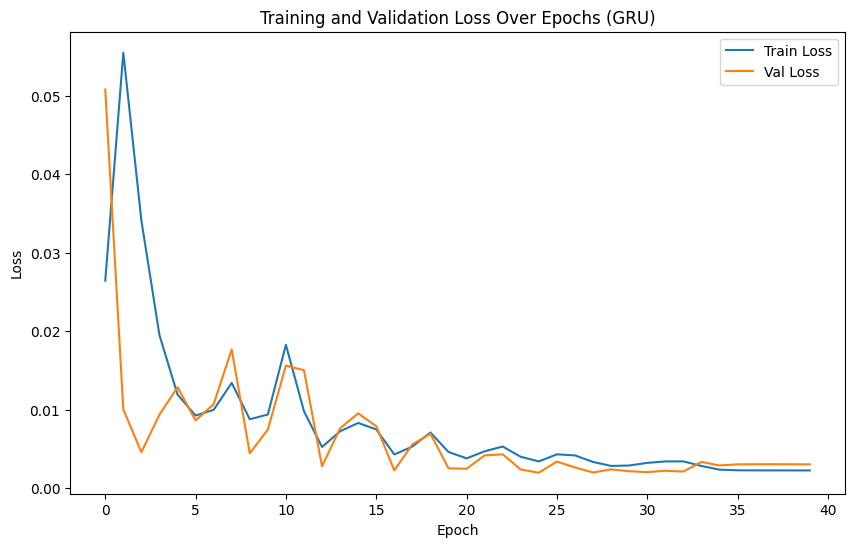

In [ ]:
# ---------------------------------------
# 9. Retrain Final Model with Best Hyperparams
# ---------------------------------------
best_params = study.best_params
model = GRUModel(input_dim=len(features), hidden_dim=best_params['hidden_dim'], output_dim=len(features)).to(device)
criterion = AsymmetricLoss(ratio=best_params['asymmetric_ratio'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=7)

best_state, _, train_losses, val_losses = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=40)
model.load_state_dict(best_state)

# Plot training vs validation loss to check for overfitting
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss Over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicted (first 5):
 [[806.59467 810.7438  798.2349  797.41736]
 [807.02747 811.18066 798.656   797.5816 ]
 [807.91864 812.0652  799.5321  798.66534]
 [809.00385 813.1384  800.5809  799.51105]
 [810.1547  814.2734  801.6925  800.89514]]
Actual (first 5):
 [[778.81 789.63 775.8  786.14]
 [788.36 791.34 783.16 786.9 ]
 [786.08 794.48 785.02 794.02]
 [795.26 807.9  792.2  806.15]
 [806.4  809.97 802.83 806.65]]
Test MSE: 193.7611, RMSE: 13.9198, MAE: 11.1518


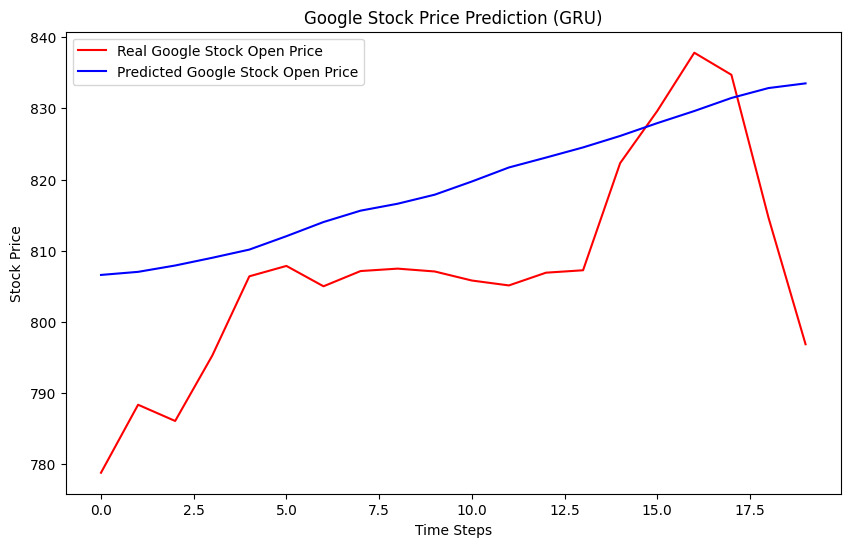

In [ ]:
# ---------------------------------------
# 10. Evaluate on Test Set
# ---------------------------------------
# Take the last N days of training plus test data to ensure proper alignment
test_input = np.concatenate((training_set[-N:], test_set), axis=0)
test_input_scaled = scaler.transform(test_input)

X_test = []
for i in range(N, len(test_input_scaled)):
    X_test.append(test_input_scaled[i-N:i, :])
X_test = np.array(X_test)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_scaled = model(X_test_torch).cpu().numpy()

predicted_stock_price = scaler.inverse_transform(predicted_scaled.reshape(-1, len(features)))
real_prices = test_data[features].values

print("Predicted (first 5):\n", predicted_stock_price[:5])
print("Actual (first 5):\n", real_prices[:5])

# Compute Evaluation Metrics
mse = mean_squared_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Focus on 'Open' price for visualization
real_open_price = real_prices[:len(predicted_stock_price), 0]
predicted_open_price = predicted_stock_price[:, 0]

# Plot predicted vs real prices
plt.figure(figsize=(10,6))
plt.plot(real_open_price, color='red', label='Real Google Stock Open Price')
plt.plot(predicted_open_price, color='blue', label='Predicted Google Stock Open Price')
plt.title('Google Stock Price Prediction (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


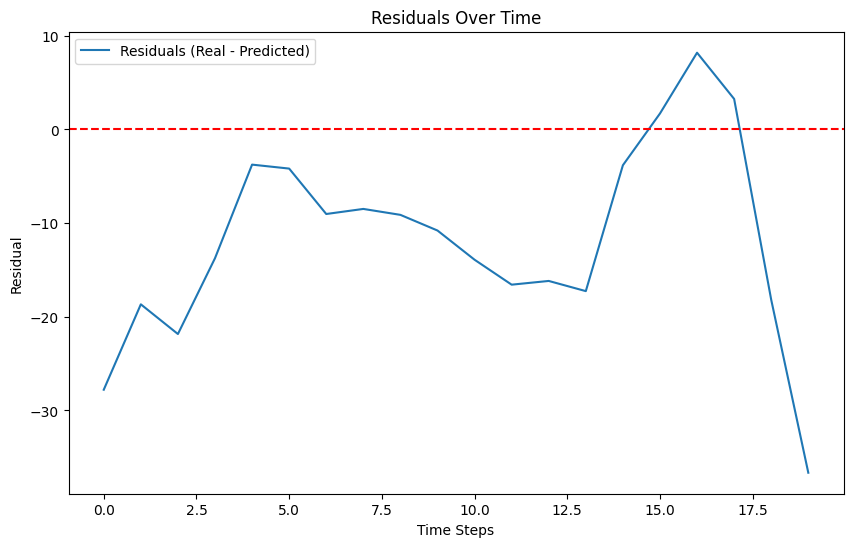

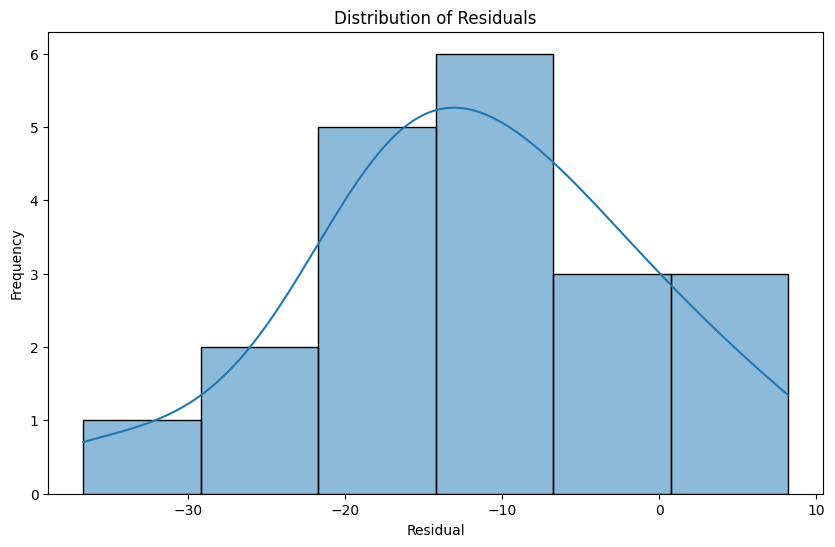

In [ ]:
# ---------------------------------------
# 11. Residual Analysis (Check for Systematic Bias)
# ---------------------------------------
residuals = real_open_price - predicted_open_price

# Plot residuals over time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Residuals (Real - Predicted)')
plt.title('Residuals Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


